# CNN-Speech Classifier
This is a notebook to train CNN model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

show a waveform sample

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


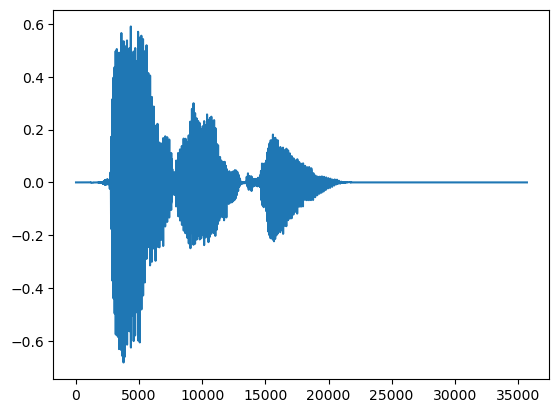

In [2]:
import os

DatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData"
waveform, sr = torchaudio.load(filepath=DatasetFilePath + "/sensitive/0.wav", frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
print(waveform)
plt.plot(waveform.t().numpy())

## Importing the dataset

In [3]:
X = []
y = []
NonDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/nonsensitive"
SenDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/sensitive"
for root, dirs, files in os.walk(NonDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(NonDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("insensitive")
for root, dirs, files in os.walk(SenDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(SenDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
X = X + X
y = y + y
NumberofSensitiveData = y.count('sensitive')
print('There are %d sensitive data' % NumberofSensitiveData)
print('There are %d nonsensitive data' % (len(y) - NumberofSensitiveData))

There are 974 sensitive data
There are 1470 nonsensitive data


Divide dataset into training set and testing set

In [4]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import torch
from torch.utils.data import Dataset


class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# get the size of the dataset
print(len(train_dataset))
print(len(test_dataset))



1955
489


In [6]:
labels = sorted(list(set(datapoint[1] for datapoint in train_dataset)))
labels

['insensitive', 'sensitive']

## Formatting Data
This is a good place to apply transformations to the data. For the waveform, we downsample the audio for faster processing without losing too much of the classification power.

In [7]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [8]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "sensitive"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

sensitive --> tensor(1) --> sensitive


In [9]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 1
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)

## Create CNN Model

In [10]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
Number

In [11]:
print(transformed.shape[0])

1


In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [13]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        #print(output.squeeze(), target)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(torch.squeeze(output, dim=0), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [14]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [19]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.01595744680851065/10 [00:00<02:05, 12.55s/it] 

Train Epoch: 1 [0/1955 (0%)]	Loss: 0.882431
Train Epoch: 1 [20/1955 (1%)]	Loss: 0.581272


  0%|          | 0.024140752864157112/10 [00:00<02:12, 13.24s/it]

Train Epoch: 1 [40/1955 (2%)]	Loss: 0.559045
Train Epoch: 1 [60/1955 (3%)]	Loss: 0.526506


  0%|          | 0.048281505728314175/10 [00:00<02:09, 13.01s/it]

Train Epoch: 1 [80/1955 (4%)]	Loss: 0.936851
Train Epoch: 1 [100/1955 (5%)]	Loss: 0.527963


  1%|          | 0.06423895253682481/10 [00:00<02:08, 12.95s/it] 

Train Epoch: 1 [120/1955 (6%)]	Loss: 0.543582
Train Epoch: 1 [140/1955 (7%)]	Loss: 0.542119


  1%|          | 0.08101472995090034/10 [00:01<02:03, 12.44s/it]

Train Epoch: 1 [160/1955 (8%)]	Loss: 0.523726
Train Epoch: 1 [180/1955 (9%)]	Loss: 0.862433
Train Epoch: 1 [200/1955 (10%)]	Loss: 0.522862


  1%|          | 0.10597381342062247/10 [00:01<02:05, 12.66s/it]

Train Epoch: 1 [220/1955 (11%)]	Loss: 0.965094
Train Epoch: 1 [240/1955 (12%)]	Loss: 0.550414


  1%|          | 0.12234042553191567/10 [00:01<02:06, 12.76s/it]

Train Epoch: 1 [260/1955 (13%)]	Loss: 0.536526
Train Epoch: 1 [280/1955 (14%)]	Loss: 0.603721


  1%|▏         | 0.1305237315875621/10 [00:01<02:12, 13.38s/it] 

Train Epoch: 1 [300/1955 (15%)]	Loss: 0.519943
Train Epoch: 1 [320/1955 (16%)]	Loss: 0.968953


  2%|▏         | 0.156301145662848/10 [00:02<02:03, 12.51s/it]  

Train Epoch: 1 [340/1955 (17%)]	Loss: 0.487752
Train Epoch: 1 [360/1955 (18%)]	Loss: 0.452530
Train Epoch: 1 [380/1955 (19%)]	Loss: 0.411935


  2%|▏         | 0.17266775777414065/10 [00:02<02:03, 12.52s/it]

Train Epoch: 1 [400/1955 (20%)]	Loss: 0.418212
Train Epoch: 1 [420/1955 (21%)]	Loss: 0.434536


  2%|▏         | 0.18985270049099792/10 [00:02<02:00, 12.30s/it]

Train Epoch: 1 [440/1955 (23%)]	Loss: 1.014184
Train Epoch: 1 [460/1955 (24%)]	Loss: 0.969290
Train Epoch: 1 [480/1955 (25%)]	Loss: 0.970415


  2%|▏         | 0.21522094926350152/10 [00:02<02:01, 12.43s/it]

Train Epoch: 1 [500/1955 (26%)]	Loss: 0.457629
Train Epoch: 1 [520/1955 (27%)]	Loss: 0.454357


  2%|▏         | 0.23158756137479417/10 [00:02<02:04, 12.79s/it]

Train Epoch: 1 [540/1955 (28%)]	Loss: 0.450296
Train Epoch: 1 [560/1955 (29%)]	Loss: 1.050543


  2%|▏         | 0.24836333878886913/10 [00:03<02:04, 12.80s/it]

Train Epoch: 1 [580/1955 (30%)]	Loss: 0.427597
Train Epoch: 1 [600/1955 (31%)]	Loss: 0.471196


  3%|▎         | 0.2651391162029451/10 [00:03<02:09, 13.31s/it] 

Train Epoch: 1 [620/1955 (32%)]	Loss: 0.956939
Train Epoch: 1 [640/1955 (33%)]	Loss: 0.949917


  3%|▎         | 0.28150572831423887/10 [00:03<02:05, 12.90s/it]

Train Epoch: 1 [660/1955 (34%)]	Loss: 0.921617
Train Epoch: 1 [680/1955 (35%)]	Loss: 0.531631


  3%|▎         | 0.2986906710310973/10 [00:03<02:01, 12.50s/it] 

Train Epoch: 1 [700/1955 (36%)]	Loss: 0.494795
Train Epoch: 1 [720/1955 (37%)]	Loss: 0.571065


  3%|▎         | 0.31505728314239106/10 [00:04<02:04, 12.86s/it]

Train Epoch: 1 [740/1955 (38%)]	Loss: 0.502683
Train Epoch: 1 [760/1955 (39%)]	Loss: 0.919887


  3%|▎         | 0.33183306055646716/10 [00:04<02:02, 12.69s/it]

Train Epoch: 1 [780/1955 (40%)]	Loss: 0.518605
Train Epoch: 1 [800/1955 (41%)]	Loss: 0.556716
Train Epoch: 1 [820/1955 (42%)]	Loss: 0.584500


  4%|▎         | 0.3563829787234078/10 [00:04<02:02, 12.71s/it] 

Train Epoch: 1 [840/1955 (43%)]	Loss: 0.852760
Train Epoch: 1 [860/1955 (44%)]	Loss: 0.843956


  4%|▎         | 0.3731587561374839/10 [00:04<01:59, 12.45s/it]

Train Epoch: 1 [880/1955 (45%)]	Loss: 0.604994
Train Epoch: 1 [900/1955 (46%)]	Loss: 0.623860
Train Epoch: 1 [920/1955 (47%)]	Loss: 0.688108


  4%|▍         | 0.3977086743044245/10 [00:05<02:08, 13.40s/it] 

Train Epoch: 1 [940/1955 (48%)]	Loss: 0.762279
Train Epoch: 1 [960/1955 (49%)]	Loss: 0.551086


  4%|▍         | 0.4140752864157183/10 [00:05<02:06, 13.21s/it] 

Train Epoch: 1 [980/1955 (50%)]	Loss: 0.938919
Train Epoch: 1 [1000/1955 (51%)]	Loss: 0.959910


  4%|▍         | 0.42962356792144735/10 [00:05<02:06, 13.18s/it]

Train Epoch: 1 [1020/1955 (52%)]	Loss: 0.502492
Train Epoch: 1 [1040/1955 (53%)]	Loss: 0.499251


  4%|▍         | 0.4468085106383058/10 [00:05<02:01, 12.67s/it] 

Train Epoch: 1 [1060/1955 (54%)]	Loss: 0.947336
Train Epoch: 1 [1080/1955 (55%)]	Loss: 0.967006


  5%|▍         | 0.4627659574468172/10 [00:05<02:13, 14.01s/it] 

Train Epoch: 1 [1100/1955 (56%)]	Loss: 0.485044
Train Epoch: 1 [1120/1955 (57%)]	Loss: 0.487291


  5%|▍         | 0.47831423895254627/10 [00:06<02:08, 13.52s/it]

Train Epoch: 1 [1140/1955 (58%)]	Loss: 0.490598
Train Epoch: 1 [1160/1955 (59%)]	Loss: 0.461509


  5%|▍         | 0.49468085106384/10 [00:06<02:05, 13.18s/it]   

Train Epoch: 1 [1180/1955 (60%)]	Loss: 0.476783
Train Epoch: 1 [1200/1955 (61%)]	Loss: 0.476515
Train Epoch: 1 [1220/1955 (62%)]	Loss: 1.012089


  5%|▌         | 0.5180032733224336/10 [00:06<02:05, 13.22s/it]

Train Epoch: 1 [1240/1955 (63%)]	Loss: 1.018179
Train Epoch: 1 [1260/1955 (64%)]	Loss: 0.945187


  5%|▌         | 0.5347790507365097/10 [00:06<02:01, 12.85s/it]

Train Epoch: 1 [1280/1955 (65%)]	Loss: 0.917033
Train Epoch: 1 [1300/1955 (66%)]	Loss: 0.516947
Train Epoch: 1 [1320/1955 (68%)]	Loss: 0.806751


  6%|▌         | 0.560147299509015/10 [00:07<01:56, 12.31s/it] 

Train Epoch: 1 [1340/1955 (69%)]	Loss: 0.711984
Train Epoch: 1 [1360/1955 (70%)]	Loss: 0.611109
Train Epoch: 1 [1380/1955 (71%)]	Loss: 0.879965


  6%|▌         | 0.5859247135843026/10 [00:07<01:52, 11.90s/it]

Train Epoch: 1 [1400/1955 (72%)]	Loss: 0.875205
Train Epoch: 1 [1420/1955 (73%)]	Loss: 0.532156
Train Epoch: 1 [1440/1955 (74%)]	Loss: 0.527445


  6%|▌         | 0.6117021276595903/10 [00:07<01:56, 12.46s/it]

Train Epoch: 1 [1460/1955 (75%)]	Loss: 0.865921
Train Epoch: 1 [1480/1955 (76%)]	Loss: 0.582860


  6%|▋         | 0.6280687397708841/10 [00:08<02:04, 13.23s/it]

Train Epoch: 1 [1500/1955 (77%)]	Loss: 0.574967
Train Epoch: 1 [1520/1955 (78%)]	Loss: 0.543659


  6%|▋         | 0.6448445171849602/10 [00:08<01:58, 12.72s/it]

Train Epoch: 1 [1540/1955 (79%)]	Loss: 0.479219
Train Epoch: 1 [1560/1955 (80%)]	Loss: 0.444836
Train Epoch: 1 [1580/1955 (81%)]	Loss: 1.051478


  7%|▋         | 0.6698036006546831/10 [00:08<01:55, 12.41s/it]

Train Epoch: 1 [1600/1955 (82%)]	Loss: 0.472344
Train Epoch: 1 [1620/1955 (83%)]	Loss: 0.472523
Train Epoch: 1 [1640/1955 (84%)]	Loss: 0.946809


  7%|▋         | 0.6959901800327531/10 [00:08<01:50, 11.92s/it]

Train Epoch: 1 [1660/1955 (85%)]	Loss: 0.522802
Train Epoch: 1 [1680/1955 (86%)]	Loss: 0.924338
Train Epoch: 1 [1700/1955 (87%)]	Loss: 0.943942


  7%|▋         | 0.7131751227496116/10 [00:09<01:50, 11.93s/it]

Train Epoch: 1 [1720/1955 (88%)]	Loss: 0.532630
Train Epoch: 1 [1740/1955 (89%)]	Loss: 0.878012
Train Epoch: 1 [1760/1955 (90%)]	Loss: 0.953159


  7%|▋         | 0.7393617021276816/10 [00:09<01:54, 12.38s/it]

Train Epoch: 1 [1780/1955 (91%)]	Loss: 0.438814
Train Epoch: 1 [1800/1955 (92%)]	Loss: 0.434160


  8%|▊         | 0.7557283142389754/10 [00:09<02:00, 12.98s/it]

Train Epoch: 1 [1820/1955 (93%)]	Loss: 0.493174
Train Epoch: 1 [1840/1955 (94%)]	Loss: 0.895635


  8%|▊         | 0.7725040916530515/10 [00:09<01:56, 12.68s/it]

Train Epoch: 1 [1860/1955 (95%)]	Loss: 0.846759
Train Epoch: 1 [1880/1955 (96%)]	Loss: 0.537647


  8%|▊         | 0.7896890343699099/10 [00:10<01:53, 12.31s/it]

Train Epoch: 1 [1900/1955 (97%)]	Loss: 0.843625
Train Epoch: 1 [1920/1955 (98%)]	Loss: 0.880405
Train Epoch: 1 [1940/1955 (99%)]	Loss: 0.566582


 10%|█         | 1.0028641571195103/10 [00:11<00:54,  6.05s/it]


Test Epoch: 1	Accuracy: 301/489 (62%)

Train Epoch: 2 [0/1955 (0%)]	Loss: 0.563104
Train Epoch: 2 [20/1955 (1%)]	Loss: 0.502438


 10%|█         | 1.0335515548281777/10 [00:11<01:21,  9.08s/it]

Train Epoch: 2 [40/1955 (2%)]	Loss: 0.471354
Train Epoch: 2 [60/1955 (3%)]	Loss: 0.469910
Train Epoch: 2 [80/1955 (4%)]	Loss: 0.941922


 10%|█         | 1.046235679214427/10 [00:11<01:27,  9.82s/it] 

Train Epoch: 2 [100/1955 (5%)]	Loss: 0.861094
Train Epoch: 2 [120/1955 (6%)]	Loss: 0.538292


 11%|█         | 1.0679214402618853/10 [00:12<01:36, 10.85s/it]

Train Epoch: 2 [140/1955 (7%)]	Loss: 0.524496
Train Epoch: 2 [160/1955 (8%)]	Loss: 0.481325
Train Epoch: 2 [180/1955 (9%)]	Loss: 0.459056


 11%|█         | 1.0965630114566416/10 [00:12<01:42, 11.49s/it]

Train Epoch: 2 [200/1955 (10%)]	Loss: 0.455995
Train Epoch: 2 [220/1955 (11%)]	Loss: 0.487449
Train Epoch: 2 [240/1955 (12%)]	Loss: 0.495722


 11%|█         | 1.123567921440269/10 [00:12<01:44, 11.74s/it] 

Train Epoch: 2 [260/1955 (13%)]	Loss: 0.474579
Train Epoch: 2 [280/1955 (14%)]	Loss: 0.461905
Train Epoch: 2 [300/1955 (15%)]	Loss: 0.504041


 11%|█▏        | 1.1407528641571227/10 [00:13<01:47, 12.14s/it]

Train Epoch: 2 [320/1955 (16%)]	Loss: 0.891659
Train Epoch: 2 [340/1955 (17%)]	Loss: 0.851902


 12%|█▏        | 1.1579378068739765/10 [00:13<01:46, 12.00s/it]

Train Epoch: 2 [360/1955 (18%)]	Loss: 0.817336
Train Epoch: 2 [380/1955 (19%)]	Loss: 0.537475
Train Epoch: 2 [400/1955 (20%)]	Loss: 0.940724


 12%|█▏        | 1.1841243862520394/10 [00:13<01:47, 12.19s/it]

Train Epoch: 2 [420/1955 (21%)]	Loss: 0.517967
Train Epoch: 2 [440/1955 (23%)]	Loss: 0.533642
Train Epoch: 2 [460/1955 (24%)]	Loss: 0.578851


 12%|█▏        | 1.2119476268412313/10 [00:13<01:45, 12.00s/it]

Train Epoch: 2 [480/1955 (25%)]	Loss: 0.712806
Train Epoch: 2 [500/1955 (26%)]	Loss: 0.846200
Train Epoch: 2 [520/1955 (27%)]	Loss: 0.823039


 12%|█▏        | 1.229132569558085/10 [00:14<01:46, 12.20s/it] 

Train Epoch: 2 [540/1955 (28%)]	Loss: 0.596849
Train Epoch: 2 [560/1955 (29%)]	Loss: 0.732159


 12%|█▏        | 1.2463175122749388/10 [00:14<01:47, 12.25s/it]

Train Epoch: 2 [580/1955 (30%)]	Loss: 0.645246
Train Epoch: 2 [600/1955 (31%)]	Loss: 0.614243
Train Epoch: 2 [620/1955 (32%)]	Loss: 0.799988


 13%|█▎        | 1.2720949263502195/10 [00:14<01:46, 12.20s/it]

Train Epoch: 2 [640/1955 (33%)]	Loss: 0.603690
Train Epoch: 2 [660/1955 (34%)]	Loss: 0.570971


 13%|█▎        | 1.288870703764291/10 [00:14<01:47, 12.37s/it] 

Train Epoch: 2 [680/1955 (35%)]	Loss: 0.875300
Train Epoch: 2 [700/1955 (36%)]	Loss: 0.548572


 13%|█▎        | 1.306464811783927/10 [00:15<01:45, 12.10s/it] 

Train Epoch: 2 [720/1955 (37%)]	Loss: 0.532057
Train Epoch: 2 [740/1955 (38%)]	Loss: 0.521049
Train Epoch: 2 [760/1955 (39%)]	Loss: 0.869952


 13%|█▎        | 1.33265139116199/10 [00:15<01:42, 11.88s/it]  

Train Epoch: 2 [780/1955 (40%)]	Loss: 0.842223
Train Epoch: 2 [800/1955 (41%)]	Loss: 0.540594
Train Epoch: 2 [820/1955 (42%)]	Loss: 0.982182


 14%|█▎        | 1.3580196399344884/10 [00:15<01:49, 12.64s/it]

Train Epoch: 2 [840/1955 (43%)]	Loss: 0.452388
Train Epoch: 2 [860/1955 (44%)]	Loss: 0.419417


 14%|█▍        | 1.3756137479541244/10 [00:15<01:44, 12.11s/it]

Train Epoch: 2 [880/1955 (45%)]	Loss: 0.432074
Train Epoch: 2 [900/1955 (46%)]	Loss: 0.456268
Train Epoch: 2 [920/1955 (47%)]	Loss: 0.968667


 14%|█▍        | 1.401391162029405/10 [00:16<01:43, 12.02s/it] 

Train Epoch: 2 [940/1955 (48%)]	Loss: 0.913864
Train Epoch: 2 [960/1955 (49%)]	Loss: 0.859918
Train Epoch: 2 [980/1955 (50%)]	Loss: 0.597562


 14%|█▍        | 1.4181669394434766/10 [00:16<01:46, 12.36s/it]

Train Epoch: 2 [1000/1955 (51%)]	Loss: 0.812766
Train Epoch: 2 [1020/1955 (52%)]	Loss: 0.587446
Train Epoch: 2 [1040/1955 (53%)]	Loss: 0.569567


 14%|█▍        | 1.4447626841243217/10 [00:16<01:43, 12.04s/it]

Train Epoch: 2 [1060/1955 (54%)]	Loss: 0.535536
Train Epoch: 2 [1080/1955 (55%)]	Loss: 0.539091
Train Epoch: 2 [1100/1955 (56%)]	Loss: 0.498769


 15%|█▍        | 1.469721767594038/10 [00:17<01:47, 12.65s/it] 

Train Epoch: 2 [1120/1955 (57%)]	Loss: 0.482493
Train Epoch: 2 [1140/1955 (58%)]	Loss: 0.996349


 15%|█▍        | 1.4860883797053273/10 [00:17<01:56, 13.72s/it]

Train Epoch: 2 [1160/1955 (59%)]	Loss: 0.485702
Train Epoch: 2 [1180/1955 (60%)]	Loss: 0.489699


 15%|█▌        | 1.5040916530277455/10 [00:17<01:46, 12.56s/it]

Train Epoch: 2 [1200/1955 (61%)]	Loss: 0.450607
Train Epoch: 2 [1220/1955 (62%)]	Loss: 1.006053
Train Epoch: 2 [1240/1955 (63%)]	Loss: 0.966745


 15%|█▌        | 1.5290507364974617/10 [00:17<01:49, 12.90s/it]

Train Epoch: 2 [1260/1955 (64%)]	Loss: 0.939350
Train Epoch: 2 [1280/1955 (65%)]	Loss: 0.525810


 15%|█▌        | 1.545417348608751/10 [00:18<01:47, 12.77s/it] 

Train Epoch: 2 [1300/1955 (66%)]	Loss: 0.538729
Train Epoch: 2 [1320/1955 (68%)]	Loss: 0.519085


 16%|█▌        | 1.5621931260228226/10 [00:18<01:45, 12.48s/it]

Train Epoch: 2 [1340/1955 (69%)]	Loss: 0.484771
Train Epoch: 2 [1360/1955 (70%)]	Loss: 0.972956


 16%|█▌        | 1.5789689034368941/10 [00:18<01:44, 12.35s/it]

Train Epoch: 2 [1380/1955 (71%)]	Loss: 0.488712
Train Epoch: 2 [1400/1955 (72%)]	Loss: 0.471152


 16%|█▌        | 1.5953355155481834/10 [00:18<01:51, 13.27s/it]

Train Epoch: 2 [1420/1955 (73%)]	Loss: 0.433650
Train Epoch: 2 [1440/1955 (74%)]	Loss: 0.422336


 16%|█▌        | 1.6117021276594727/10 [00:18<01:47, 12.82s/it]

Train Epoch: 2 [1460/1955 (75%)]	Loss: 0.468701
Train Epoch: 2 [1480/1955 (76%)]	Loss: 0.523809


 16%|█▋        | 1.6284779050735443/10 [00:19<01:46, 12.70s/it]

Train Epoch: 2 [1500/1955 (77%)]	Loss: 0.530528
Train Epoch: 2 [1520/1955 (78%)]	Loss: 0.516400
Train Epoch: 2 [1540/1955 (79%)]	Loss: 0.950749


 17%|█▋        | 1.6530278232404783/10 [00:19<01:47, 12.91s/it]

Train Epoch: 2 [1560/1955 (80%)]	Loss: 0.511390
Train Epoch: 2 [1580/1955 (81%)]	Loss: 0.519331


 17%|█▋        | 1.6698036006545498/10 [00:19<01:44, 12.50s/it]

Train Epoch: 2 [1600/1955 (82%)]	Loss: 0.917933
Train Epoch: 2 [1620/1955 (83%)]	Loss: 0.879544
Train Epoch: 2 [1640/1955 (84%)]	Loss: 0.524594


 17%|█▋        | 1.6951718494270482/10 [00:19<01:42, 12.39s/it]

Train Epoch: 2 [1660/1955 (85%)]	Loss: 0.526508
Train Epoch: 2 [1680/1955 (86%)]	Loss: 0.508885
Train Epoch: 2 [1700/1955 (87%)]	Loss: 0.480006


 17%|█▋        | 1.7131751227494665/10 [00:20<01:41, 12.21s/it]

Train Epoch: 2 [1720/1955 (88%)]	Loss: 0.971444
Train Epoch: 2 [1740/1955 (89%)]	Loss: 0.509987


 17%|█▋        | 1.7303600654663203/10 [00:20<01:44, 12.69s/it]

Train Epoch: 2 [1760/1955 (90%)]	Loss: 0.949672
Train Epoch: 2 [1780/1955 (91%)]	Loss: 0.933398


 17%|█▋        | 1.7471358428803918/10 [00:20<01:45, 12.76s/it]

Train Epoch: 2 [1800/1955 (92%)]	Loss: 0.544511
Train Epoch: 2 [1820/1955 (93%)]	Loss: 0.525942


 18%|█▊        | 1.7639116202944634/10 [00:20<01:43, 12.61s/it]

Train Epoch: 2 [1840/1955 (94%)]	Loss: 0.553790
Train Epoch: 2 [1860/1955 (95%)]	Loss: 0.542297


 18%|█▊        | 1.7810965630113171/10 [00:20<01:40, 12.23s/it]

Train Epoch: 2 [1880/1955 (96%)]	Loss: 0.891237
Train Epoch: 2 [1900/1955 (97%)]	Loss: 0.935170
Train Epoch: 2 [1920/1955 (98%)]	Loss: 0.540317


 18%|█▊        | 1.8146481178394602/10 [00:21<01:18,  9.61s/it]

Train Epoch: 2 [1940/1955 (99%)]	Loss: 0.869143


 20%|██        | 2.0032733224220713/10 [00:22<00:47,  5.92s/it]


Test Epoch: 2	Accuracy: 301/489 (62%)

Train Epoch: 3 [0/1955 (0%)]	Loss: 0.910908
Train Epoch: 3 [20/1955 (1%)]	Loss: 0.477286
Train Epoch: 3 [40/1955 (2%)]	Loss: 0.473829


 20%|██        | 2.035188216039103/10 [00:22<01:09,  8.74s/it] 

Train Epoch: 3 [60/1955 (3%)]	Loss: 0.472904
Train Epoch: 3 [80/1955 (4%)]	Loss: 0.485003


 20%|██        | 2.047872340425359/10 [00:22<01:16,  9.65s/it]

Train Epoch: 3 [100/1955 (5%)]	Loss: 0.895739
Train Epoch: 3 [120/1955 (6%)]	Loss: 0.868453
Train Epoch: 3 [140/1955 (7%)]	Loss: 0.853459


 21%|██        | 2.080196399345173/10 [00:23<01:27, 11.03s/it] 

Train Epoch: 3 [160/1955 (8%)]	Loss: 0.554980
Train Epoch: 3 [180/1955 (9%)]	Loss: 0.546634
Train Epoch: 3 [200/1955 (10%)]	Loss: 0.557089


 21%|██        | 2.099018003273166/10 [00:23<01:27, 11.13s/it] 

Train Epoch: 3 [220/1955 (11%)]	Loss: 0.851376
Train Epoch: 3 [240/1955 (12%)]	Loss: 0.561279
Train Epoch: 3 [260/1955 (13%)]	Loss: 0.515631


 21%|██▏       | 2.1264320785595903/10 [00:23<01:32, 11.75s/it]

Train Epoch: 3 [280/1955 (14%)]	Loss: 0.888871
Train Epoch: 3 [300/1955 (15%)]	Loss: 0.892097
Train Epoch: 3 [320/1955 (16%)]	Loss: 0.823092


 22%|██▏       | 2.152209492634885/10 [00:24<01:33, 11.94s/it] 

Train Epoch: 3 [340/1955 (17%)]	Loss: 0.615138
Train Epoch: 3 [360/1955 (18%)]	Loss: 0.606480
Train Epoch: 3 [380/1955 (19%)]	Loss: 0.593258


 22%|██▏       | 2.1771685761046147/10 [00:24<01:40, 12.89s/it]

Train Epoch: 3 [400/1955 (20%)]	Loss: 0.595543
Train Epoch: 3 [420/1955 (21%)]	Loss: 0.827422


 22%|██▏       | 2.193535188215913/10 [00:24<01:39, 12.69s/it] 

Train Epoch: 3 [440/1955 (23%)]	Loss: 0.539670
Train Epoch: 3 [460/1955 (24%)]	Loss: 0.463855
Train Epoch: 3 [480/1955 (25%)]	Loss: 0.463525


 22%|██▏       | 2.21808510638286/10 [00:25<01:42, 13.15s/it]  

Train Epoch: 3 [500/1955 (26%)]	Loss: 0.477452
Train Epoch: 3 [520/1955 (27%)]	Loss: 0.964541


 22%|██▏       | 2.2344517184941584/10 [00:25<01:41, 13.06s/it]

Train Epoch: 3 [540/1955 (28%)]	Loss: 0.538624
Train Epoch: 3 [560/1955 (29%)]	Loss: 0.555031
Train Epoch: 3 [580/1955 (30%)]	Loss: 0.868480


 23%|██▎       | 2.2606382978722355/10 [00:25<01:34, 12.15s/it]

Train Epoch: 3 [600/1955 (31%)]	Loss: 0.841637
Train Epoch: 3 [620/1955 (32%)]	Loss: 0.561614
Train Epoch: 3 [640/1955 (33%)]	Loss: 0.541104


 23%|██▎       | 2.2778232405890986/10 [00:25<01:33, 12.13s/it]

Train Epoch: 3 [660/1955 (34%)]	Loss: 0.503470
Train Epoch: 3 [680/1955 (35%)]	Loss: 0.912369


 23%|██▎       | 2.3031914893616108/10 [00:26<01:36, 12.53s/it]

Train Epoch: 3 [700/1955 (36%)]	Loss: 0.536507
Train Epoch: 3 [720/1955 (37%)]	Loss: 0.524389
Train Epoch: 3 [740/1955 (38%)]	Loss: 0.533350


 23%|██▎       | 2.3199672667756914/10 [00:26<01:35, 12.47s/it]

Train Epoch: 3 [760/1955 (39%)]	Loss: 0.518650
Train Epoch: 3 [780/1955 (40%)]	Loss: 0.476338


 23%|██▎       | 2.3363338788869896/10 [00:26<01:38, 12.84s/it]

Train Epoch: 3 [800/1955 (41%)]	Loss: 0.484013
Train Epoch: 3 [820/1955 (42%)]	Loss: 0.515242


 24%|██▎       | 2.3531096563010703/10 [00:26<01:38, 12.92s/it]

Train Epoch: 3 [840/1955 (43%)]	Loss: 0.559453
Train Epoch: 3 [860/1955 (44%)]	Loss: 0.859752


 24%|██▎       | 2.3686579378068036/10 [00:26<01:39, 13.06s/it]

Train Epoch: 3 [880/1955 (45%)]	Loss: 0.539403
Train Epoch: 3 [900/1955 (46%)]	Loss: 0.952713


 24%|██▍       | 2.392389525368186/10 [00:27<01:37, 12.87s/it] 

Train Epoch: 3 [920/1955 (47%)]	Loss: 0.495044
Train Epoch: 3 [940/1955 (48%)]	Loss: 0.908438


 24%|██▍       | 2.4009819967266175/10 [00:27<01:35, 12.56s/it]

Train Epoch: 3 [960/1955 (49%)]	Loss: 0.493177
Train Epoch: 3 [980/1955 (50%)]	Loss: 0.968436


 24%|██▍       | 2.4169394435351332/10 [00:27<01:41, 13.37s/it]

Train Epoch: 3 [1000/1955 (51%)]	Loss: 0.504247
Train Epoch: 3 [1020/1955 (52%)]	Loss: 0.496749


 24%|██▍       | 2.4414893617020805/10 [00:27<01:36, 12.78s/it]

Train Epoch: 3 [1040/1955 (53%)]	Loss: 0.894570
Train Epoch: 3 [1060/1955 (54%)]	Loss: 0.502428


 24%|██▍       | 2.4496726677577296/10 [00:27<01:36, 12.77s/it]

Train Epoch: 3 [1080/1955 (55%)]	Loss: 0.472071
Train Epoch: 3 [1100/1955 (56%)]	Loss: 0.492256


 25%|██▍       | 2.475040916530242/10 [00:28<01:33, 12.40s/it] 

Train Epoch: 3 [1120/1955 (57%)]	Loss: 0.529789
Train Epoch: 3 [1140/1955 (58%)]	Loss: 0.528978
Train Epoch: 3 [1160/1955 (59%)]	Loss: 0.513048


 25%|██▍       | 2.4926350245498874/10 [00:28<01:32, 12.32s/it]

Train Epoch: 3 [1180/1955 (60%)]	Loss: 0.497611
Train Epoch: 3 [1200/1955 (61%)]	Loss: 0.931162


 25%|██▌       | 2.509410801963968/10 [00:28<01:31, 12.25s/it] 

Train Epoch: 3 [1220/1955 (62%)]	Loss: 0.901697
Train Epoch: 3 [1240/1955 (63%)]	Loss: 0.537764


 25%|██▌       | 2.5257774140752662/10 [00:28<01:34, 12.70s/it]

Train Epoch: 3 [1260/1955 (64%)]	Loss: 0.525480
Train Epoch: 3 [1280/1955 (65%)]	Loss: 0.929624


 25%|██▌       | 2.542553191489347/10 [00:29<01:37, 13.02s/it] 

Train Epoch: 3 [1300/1955 (66%)]	Loss: 0.520454
Train Epoch: 3 [1320/1955 (68%)]	Loss: 1.001671


 26%|██▌       | 2.5593289689034275/10 [00:29<01:34, 12.69s/it]

Train Epoch: 3 [1340/1955 (69%)]	Loss: 0.473842
Train Epoch: 3 [1360/1955 (70%)]	Loss: 0.911165
Train Epoch: 3 [1380/1955 (71%)]	Loss: 0.539367


 26%|██▌       | 2.5834697217675924/10 [00:29<01:37, 13.09s/it]

Train Epoch: 3 [1400/1955 (72%)]	Loss: 0.525212
Train Epoch: 3 [1420/1955 (73%)]	Loss: 0.496803


 26%|██▌       | 2.5990180032733257/10 [00:29<01:38, 13.34s/it]

Train Epoch: 3 [1440/1955 (74%)]	Loss: 0.447481
Train Epoch: 3 [1460/1955 (75%)]	Loss: 1.011446


 26%|██▌       | 2.616612111292971/10 [00:30<01:31, 12.42s/it] 

Train Epoch: 3 [1480/1955 (76%)]	Loss: 0.465797
Train Epoch: 3 [1500/1955 (77%)]	Loss: 0.458862
Train Epoch: 3 [1520/1955 (78%)]	Loss: 0.483419


 26%|██▋       | 2.642389525368266/10 [00:30<01:33, 12.73s/it] 

Train Epoch: 3 [1540/1955 (79%)]	Loss: 0.496665
Train Epoch: 3 [1560/1955 (80%)]	Loss: 0.542334


 27%|██▋       | 2.658756137479564/10 [00:30<01:35, 13.01s/it]

Train Epoch: 3 [1580/1955 (81%)]	Loss: 0.818821
Train Epoch: 3 [1600/1955 (82%)]	Loss: 0.539582


 27%|██▋       | 2.6755319148936447/10 [00:30<01:32, 12.59s/it]

Train Epoch: 3 [1620/1955 (83%)]	Loss: 0.491692
Train Epoch: 3 [1640/1955 (84%)]	Loss: 0.472872


 27%|██▋       | 2.6923076923077254/10 [00:31<01:38, 13.43s/it]

Train Epoch: 3 [1660/1955 (85%)]	Loss: 1.005161
Train Epoch: 3 [1680/1955 (86%)]	Loss: 0.937257


 27%|██▋       | 2.7094926350245885/10 [00:31<01:34, 13.02s/it]

Train Epoch: 3 [1700/1955 (87%)]	Loss: 0.918402
Train Epoch: 3 [1720/1955 (88%)]	Loss: 0.911544


 27%|██▋       | 2.726268412438669/10 [00:31<01:31, 12.58s/it] 

Train Epoch: 3 [1740/1955 (89%)]	Loss: 0.516680
Train Epoch: 3 [1760/1955 (90%)]	Loss: 0.512946
Train Epoch: 3 [1780/1955 (91%)]	Loss: 0.520089


 28%|██▊       | 2.7508183306056164/10 [00:31<01:30, 12.51s/it]

Train Epoch: 3 [1800/1955 (92%)]	Loss: 0.483064
Train Epoch: 3 [1820/1955 (93%)]	Loss: 0.917653
Train Epoch: 3 [1840/1955 (94%)]	Loss: 0.523839


 28%|██▊       | 2.776595744680911/10 [00:32<01:28, 12.31s/it] 

Train Epoch: 3 [1860/1955 (95%)]	Loss: 0.508587
Train Epoch: 3 [1880/1955 (96%)]	Loss: 0.507504
Train Epoch: 3 [1900/1955 (97%)]	Loss: 0.931037


 28%|██▊       | 2.8048281505729005/10 [00:32<01:19, 11.06s/it]

Train Epoch: 3 [1920/1955 (98%)]	Loss: 0.484077
Train Epoch: 3 [1940/1955 (99%)]	Loss: 0.479991


 30%|███       | 3.004909983633521/10 [00:33<00:39,  5.59s/it] 


Test Epoch: 3	Accuracy: 301/489 (62%)

Train Epoch: 4 [0/1955 (0%)]	Loss: 0.969621
Train Epoch: 4 [20/1955 (1%)]	Loss: 0.502667
Train Epoch: 4 [40/1955 (2%)]	Loss: 0.503603


 30%|███       | 3.0388707037644647/10 [00:33<00:57,  8.25s/it]

Train Epoch: 4 [60/1955 (3%)]	Loss: 0.939455
Train Epoch: 4 [80/1955 (4%)]	Loss: 0.496111
Train Epoch: 4 [100/1955 (5%)]	Loss: 0.472800


 31%|███       | 3.0646481178397593/10 [00:34<01:06,  9.61s/it]

Train Epoch: 4 [120/1955 (6%)]	Loss: 1.037031
Train Epoch: 4 [140/1955 (7%)]	Loss: 0.453090
Train Epoch: 4 [160/1955 (8%)]	Loss: 0.459611


 31%|███       | 3.085924713584447/10 [00:34<01:12, 10.45s/it] 

Train Epoch: 4 [180/1955 (9%)]	Loss: 0.986433
Train Epoch: 4 [200/1955 (10%)]	Loss: 0.521860
Train Epoch: 4 [220/1955 (11%)]	Loss: 0.520921


 31%|███       | 3.1141571194764364/10 [00:34<01:20, 11.69s/it]

Train Epoch: 4 [240/1955 (12%)]	Loss: 0.536989
Train Epoch: 4 [260/1955 (13%)]	Loss: 0.884388
Train Epoch: 4 [280/1955 (14%)]	Loss: 0.887139


 31%|███▏      | 3.1321603927988644/10 [00:34<01:19, 11.60s/it]

Train Epoch: 4 [300/1955 (15%)]	Loss: 0.512301
Train Epoch: 4 [320/1955 (16%)]	Loss: 0.519947
Train Epoch: 4 [340/1955 (17%)]	Loss: 0.510633


 32%|███▏      | 3.1599836333880713/10 [00:35<01:17, 11.30s/it]

Train Epoch: 4 [360/1955 (18%)]	Loss: 0.959686
Train Epoch: 4 [380/1955 (19%)]	Loss: 0.486465
Train Epoch: 4 [400/1955 (20%)]	Loss: 0.946299


 32%|███▏      | 3.1869885433717133/10 [00:35<01:20, 11.81s/it]

Train Epoch: 4 [420/1955 (21%)]	Loss: 0.513689
Train Epoch: 4 [440/1955 (23%)]	Loss: 0.577137


 32%|███▏      | 3.2041734860885764/10 [00:35<01:19, 11.76s/it]

Train Epoch: 4 [460/1955 (24%)]	Loss: 0.537164
Train Epoch: 4 [480/1955 (25%)]	Loss: 0.540470
Train Epoch: 4 [500/1955 (26%)]	Loss: 0.927491


 32%|███▏      | 3.221767594108222/10 [00:36<01:19, 11.78s/it] 

Train Epoch: 4 [520/1955 (27%)]	Loss: 0.486376
Train Epoch: 4 [540/1955 (28%)]	Loss: 0.889543
Train Epoch: 4 [560/1955 (29%)]	Loss: 0.556889


 33%|███▎      | 3.250409165302994/10 [00:36<01:16, 11.38s/it] 

Train Epoch: 4 [580/1955 (30%)]	Loss: 0.920658
Train Epoch: 4 [600/1955 (31%)]	Loss: 0.526239
Train Epoch: 4 [620/1955 (32%)]	Loss: 0.519319


 33%|███▎      | 3.2782324058922008/10 [00:36<01:15, 11.18s/it]

Train Epoch: 4 [640/1955 (33%)]	Loss: 0.511409
Train Epoch: 4 [660/1955 (34%)]	Loss: 0.916597
Train Epoch: 4 [680/1955 (35%)]	Loss: 0.489208


 33%|███▎      | 3.2958265139118463/10 [00:36<01:20, 12.03s/it]

Train Epoch: 4 [700/1955 (36%)]	Loss: 0.457001
Train Epoch: 4 [720/1955 (37%)]	Loss: 1.064650
Train Epoch: 4 [740/1955 (38%)]	Loss: 1.032133


 33%|███▎      | 3.323240589198271/10 [00:37<01:20, 12.03s/it] 

Train Epoch: 4 [760/1955 (39%)]	Loss: 0.472223
Train Epoch: 4 [780/1955 (40%)]	Loss: 0.505299
Train Epoch: 4 [800/1955 (41%)]	Loss: 0.894575


 33%|███▎      | 3.349427168576348/10 [00:37<01:18, 11.85s/it] 

Train Epoch: 4 [820/1955 (42%)]	Loss: 0.520978
Train Epoch: 4 [840/1955 (43%)]	Loss: 0.931654
Train Epoch: 4 [860/1955 (44%)]	Loss: 0.519170


 34%|███▍      | 3.3768412438627724/10 [00:37<01:18, 11.83s/it]

Train Epoch: 4 [880/1955 (45%)]	Loss: 0.554143
Train Epoch: 4 [900/1955 (46%)]	Loss: 0.940508
Train Epoch: 4 [920/1955 (47%)]	Loss: 0.530792


 34%|███▍      | 3.395253682487983/10 [00:38<01:15, 11.48s/it] 

Train Epoch: 4 [940/1955 (48%)]	Loss: 0.513962
Train Epoch: 4 [960/1955 (49%)]	Loss: 0.508598
Train Epoch: 4 [980/1955 (50%)]	Loss: 0.520172


 34%|███▍      | 3.4226677577744073/10 [00:38<01:17, 11.76s/it]

Train Epoch: 4 [1000/1955 (51%)]	Loss: 0.864497
Train Epoch: 4 [1020/1955 (52%)]	Loss: 0.852587
Train Epoch: 4 [1040/1955 (53%)]	Loss: 0.618690


 35%|███▍      | 3.4504909983636143/10 [00:38<01:13, 11.28s/it]

Train Epoch: 4 [1060/1955 (54%)]	Loss: 0.319453
Train Epoch: 4 [1080/1955 (55%)]	Loss: 0.599211
Train Epoch: 4 [1100/1955 (56%)]	Loss: 0.572008


 35%|███▍      | 3.46808510638326/10 [00:38<01:18, 11.96s/it]  

Train Epoch: 4 [1120/1955 (57%)]	Loss: 0.628688
Train Epoch: 4 [1140/1955 (58%)]	Loss: 0.592512
Train Epoch: 4 [1160/1955 (59%)]	Loss: 0.847889


 35%|███▍      | 3.4946808510641194/10 [00:39<01:17, 11.94s/it]

Train Epoch: 4 [1180/1955 (60%)]	Loss: 0.823171
Train Epoch: 4 [1200/1955 (61%)]	Loss: 0.610464
Train Epoch: 4 [1220/1955 (62%)]	Loss: 0.828918


 35%|███▌      | 3.520458265139414/10 [00:39<01:22, 12.70s/it] 

Train Epoch: 4 [1240/1955 (63%)]	Loss: 0.826156
Train Epoch: 4 [1260/1955 (64%)]	Loss: 0.588459


 35%|███▌      | 3.5368248772507123/10 [00:39<01:21, 12.55s/it]

Train Epoch: 4 [1280/1955 (65%)]	Loss: 0.816205
Train Epoch: 4 [1300/1955 (66%)]	Loss: 0.559670


 36%|███▌      | 3.554418985270358/10 [00:39<01:20, 12.56s/it] 

Train Epoch: 4 [1320/1955 (68%)]	Loss: 0.525835
Train Epoch: 4 [1340/1955 (69%)]	Loss: 0.928595


 36%|███▌      | 3.5720130932900034/10 [00:40<01:17, 12.02s/it]

Train Epoch: 4 [1360/1955 (70%)]	Loss: 0.491853
Train Epoch: 4 [1380/1955 (71%)]	Loss: 0.490193
Train Epoch: 4 [1400/1955 (72%)]	Loss: 0.934617


 36%|███▌      | 3.596972176759733/10 [00:40<01:21, 12.67s/it] 

Train Epoch: 4 [1420/1955 (73%)]	Loss: 0.902784
Train Epoch: 4 [1440/1955 (74%)]	Loss: 0.498430


 36%|███▌      | 3.6051554828153822/10 [00:40<01:22, 12.93s/it]

Train Epoch: 4 [1460/1955 (75%)]	Loss: 0.494532
Train Epoch: 4 [1480/1955 (76%)]	Loss: 0.890445


 36%|███▌      | 3.621931260229463/10 [00:40<01:21, 12.85s/it] 

Train Epoch: 4 [1500/1955 (77%)]	Loss: 0.839938
Train Epoch: 4 [1520/1955 (78%)]	Loss: 0.828208
Train Epoch: 4 [1540/1955 (79%)]	Loss: 0.528755


 36%|███▋      | 3.6477086743047575/10 [00:41<01:17, 12.19s/it]

Train Epoch: 4 [1560/1955 (80%)]	Loss: 0.481666
Train Epoch: 4 [1580/1955 (81%)]	Loss: 1.070638
Train Epoch: 4 [1600/1955 (82%)]	Loss: 0.424403


 37%|███▋      | 3.6747135842883996/10 [00:41<01:13, 11.56s/it]

Train Epoch: 4 [1620/1955 (83%)]	Loss: 0.413341
Train Epoch: 4 [1640/1955 (84%)]	Loss: 0.422258
Train Epoch: 4 [1660/1955 (85%)]	Loss: 0.406037


 37%|███▋      | 3.701309328969259/10 [00:41<01:15, 11.91s/it] 

Train Epoch: 4 [1680/1955 (86%)]	Loss: 1.124090
Train Epoch: 4 [1700/1955 (87%)]	Loss: 0.433496


 37%|███▋      | 3.7184942716861222/10 [00:41<01:16, 12.17s/it]

Train Epoch: 4 [1720/1955 (88%)]	Loss: 0.448734
Train Epoch: 4 [1740/1955 (89%)]	Loss: 0.968389


 37%|███▋      | 3.735270049100203/10 [00:42<01:17, 12.37s/it] 

Train Epoch: 4 [1760/1955 (90%)]	Loss: 0.488893
Train Epoch: 4 [1780/1955 (91%)]	Loss: 0.954807


 38%|███▊      | 3.751636661211501/10 [00:42<01:18, 12.63s/it]

Train Epoch: 4 [1800/1955 (92%)]	Loss: 0.933674
Train Epoch: 4 [1820/1955 (93%)]	Loss: 0.473617


 38%|███▊      | 3.7684124386255817/10 [00:42<01:19, 12.78s/it]

Train Epoch: 4 [1840/1955 (94%)]	Loss: 0.480249
Train Epoch: 4 [1860/1955 (95%)]	Loss: 0.470367


 38%|███▊      | 3.785597381342445/10 [00:42<01:15, 12.22s/it] 

Train Epoch: 4 [1880/1955 (96%)]	Loss: 1.020712
Train Epoch: 4 [1900/1955 (97%)]	Loss: 0.990129
Train Epoch: 4 [1920/1955 (98%)]	Loss: 0.480146


 38%|███▊      | 3.8044189852704378/10 [00:43<01:11, 11.59s/it]

Train Epoch: 4 [1940/1955 (99%)]	Loss: 0.480398


 40%|████      | 4.010229132570013/10 [00:44<00:40,  6.81s/it] 


Test Epoch: 4	Accuracy: 301/489 (62%)

Train Epoch: 5 [0/1955 (0%)]	Loss: 0.506533
Train Epoch: 5 [20/1955 (1%)]	Loss: 0.512662


 40%|████      | 4.026186579378528/10 [00:44<00:49,  8.30s/it]

Train Epoch: 5 [40/1955 (2%)]	Loss: 0.457263
Train Epoch: 5 [60/1955 (3%)]	Loss: 1.017736


 40%|████      | 4.039689034370349/10 [00:44<00:56,  9.44s/it]

Train Epoch: 5 [80/1955 (4%)]	Loss: 1.032475
Train Epoch: 5 [100/1955 (5%)]	Loss: 0.444668


 41%|████      | 4.062193126023384/10 [00:44<01:02, 10.53s/it] 

Train Epoch: 5 [120/1955 (6%)]	Loss: 0.945174
Train Epoch: 5 [140/1955 (7%)]	Loss: 0.609191


 41%|████      | 4.081833060556942/10 [00:45<01:06, 11.30s/it]

Train Epoch: 5 [160/1955 (8%)]	Loss: 0.925143
Train Epoch: 5 [180/1955 (9%)]	Loss: 0.491780
Train Epoch: 5 [200/1955 (10%)]	Loss: 0.969139


 41%|████      | 4.100245499182153/10 [00:45<01:10, 11.95s/it]

Train Epoch: 5 [220/1955 (11%)]	Loss: 0.497760
Train Epoch: 5 [240/1955 (12%)]	Loss: 0.494187


 41%|████      | 4.117839607201798/10 [00:45<01:11, 12.09s/it]

Train Epoch: 5 [260/1955 (13%)]	Loss: 0.501294
Train Epoch: 5 [280/1955 (14%)]	Loss: 0.944191
Train Epoch: 5 [300/1955 (15%)]	Loss: 0.513728


 41%|████▏     | 4.14320785597431/10 [00:45<01:13, 12.50s/it] 

Train Epoch: 5 [320/1955 (16%)]	Loss: 0.543447
Train Epoch: 5 [340/1955 (17%)]	Loss: 0.834512
Train Epoch: 5 [360/1955 (18%)]	Loss: 0.567122


 42%|████▏     | 4.1693944353523875/10 [00:46<01:10, 12.06s/it]

Train Epoch: 5 [380/1955 (19%)]	Loss: 0.540898
Train Epoch: 5 [400/1955 (20%)]	Loss: 0.485871
Train Epoch: 5 [420/1955 (21%)]	Loss: 0.960589


 42%|████▏     | 4.195581014730465/10 [00:46<01:10, 12.20s/it] 

Train Epoch: 5 [440/1955 (23%)]	Loss: 0.913347
Train Epoch: 5 [460/1955 (24%)]	Loss: 0.504092
Train Epoch: 5 [480/1955 (25%)]	Loss: 0.484323


 42%|████▏     | 4.222176759411324/10 [00:46<01:09, 11.97s/it]

Train Epoch: 5 [500/1955 (26%)]	Loss: 0.950398
Train Epoch: 5 [520/1955 (27%)]	Loss: 0.949546
Train Epoch: 5 [540/1955 (28%)]	Loss: 0.531380


 42%|████▏     | 4.238952536825405/10 [00:47<01:16, 13.21s/it]

Train Epoch: 5 [560/1955 (29%)]	Loss: 0.884634
Train Epoch: 5 [580/1955 (30%)]	Loss: 0.510761


 43%|████▎     | 4.256137479542268/10 [00:47<01:11, 12.39s/it]

Train Epoch: 5 [600/1955 (31%)]	Loss: 0.888367
Train Epoch: 5 [620/1955 (32%)]	Loss: 0.511241
Train Epoch: 5 [640/1955 (33%)]	Loss: 0.932336


 43%|████▎     | 4.281914893617563/10 [00:47<01:08, 12.01s/it] 

Train Epoch: 5 [660/1955 (34%)]	Loss: 0.525755
Train Epoch: 5 [680/1955 (35%)]	Loss: 0.500280
Train Epoch: 5 [700/1955 (36%)]	Loss: 0.504496


 43%|████▎     | 4.307692307692857/10 [00:47<01:08, 11.97s/it]

Train Epoch: 5 [720/1955 (37%)]	Loss: 0.894850
Train Epoch: 5 [740/1955 (38%)]	Loss: 0.590417
Train Epoch: 5 [760/1955 (39%)]	Loss: 0.604855


 43%|████▎     | 4.333878887070934/10 [00:48<01:09, 12.25s/it]

Train Epoch: 5 [780/1955 (40%)]	Loss: 0.810502
Train Epoch: 5 [800/1955 (41%)]	Loss: 0.565563


 44%|████▎     | 4.3510638297877975/10 [00:48<01:09, 12.26s/it]

Train Epoch: 5 [820/1955 (42%)]	Loss: 0.866669
Train Epoch: 5 [840/1955 (43%)]	Loss: 0.847243
Train Epoch: 5 [860/1955 (44%)]	Loss: 0.858352


 44%|████▎     | 4.3690671031102255/10 [00:48<01:07, 12.04s/it]

Train Epoch: 5 [880/1955 (45%)]	Loss: 0.581122
Train Epoch: 5 [900/1955 (46%)]	Loss: 0.582825


 44%|████▍     | 4.386252045827089/10 [00:48<01:07, 11.95s/it] 

Train Epoch: 5 [920/1955 (47%)]	Loss: 0.828982
Train Epoch: 5 [940/1955 (48%)]	Loss: 0.556143


 44%|████▍     | 4.404255319149517/10 [00:49<01:06, 11.83s/it]

Train Epoch: 5 [960/1955 (49%)]	Loss: 0.564193
Train Epoch: 5 [980/1955 (50%)]	Loss: 0.811591
Train Epoch: 5 [1000/1955 (51%)]	Loss: 0.596485


 44%|████▍     | 4.430032733224811/10 [00:49<01:09, 12.47s/it]

Train Epoch: 5 [1020/1955 (52%)]	Loss: 0.569682
Train Epoch: 5 [1040/1955 (53%)]	Loss: 0.858804


 44%|████▍     | 4.446808510638892/10 [00:49<01:09, 12.56s/it]

Train Epoch: 5 [1060/1955 (54%)]	Loss: 0.549016
Train Epoch: 5 [1080/1955 (55%)]	Loss: 0.821689
Train Epoch: 5 [1100/1955 (56%)]	Loss: 0.582521


 45%|████▍     | 4.474631751228099/10 [00:49<01:03, 11.45s/it]

Train Epoch: 5 [1120/1955 (57%)]	Loss: 0.449154
Train Epoch: 5 [1140/1955 (58%)]	Loss: 1.039298
Train Epoch: 5 [1160/1955 (59%)]	Loss: 0.780343


 45%|████▍     | 4.492225859247744/10 [00:50<01:12, 13.11s/it]

Train Epoch: 5 [1180/1955 (60%)]	Loss: 0.651181
Train Epoch: 5 [1200/1955 (61%)]	Loss: 0.606992


 45%|████▌     | 4.509001636661825/10 [00:50<01:09, 12.72s/it]

Train Epoch: 5 [1220/1955 (62%)]	Loss: 0.557621
Train Epoch: 5 [1240/1955 (63%)]	Loss: 0.549567
Train Epoch: 5 [1260/1955 (64%)]	Loss: 0.526761


 45%|████▌     | 4.5364157119482496/10 [00:50<01:04, 11.73s/it]

Train Epoch: 5 [1280/1955 (65%)]	Loss: 0.892789
Train Epoch: 5 [1300/1955 (66%)]	Loss: 0.898387
Train Epoch: 5 [1320/1955 (68%)]	Loss: 0.517395


 46%|████▌     | 4.563011456629109/10 [00:51<01:04, 11.94s/it] 

Train Epoch: 5 [1340/1955 (69%)]	Loss: 0.520423
Train Epoch: 5 [1360/1955 (70%)]	Loss: 0.523366
Train Epoch: 5 [1380/1955 (71%)]	Loss: 0.485306


 46%|████▌     | 4.589607201309969/10 [00:51<01:03, 11.77s/it]

Train Epoch: 5 [1400/1955 (72%)]	Loss: 0.978551
Train Epoch: 5 [1420/1955 (73%)]	Loss: 0.879380
Train Epoch: 5 [1440/1955 (74%)]	Loss: 0.836760


 46%|████▌     | 4.607610474632397/10 [00:51<01:03, 11.75s/it]

Train Epoch: 5 [1460/1955 (75%)]	Loss: 0.596117
Train Epoch: 5 [1480/1955 (76%)]	Loss: 0.543951
Train Epoch: 5 [1500/1955 (77%)]	Loss: 0.508891


 46%|████▋     | 4.634615384616039/10 [00:51<01:04, 11.96s/it]

Train Epoch: 5 [1520/1955 (78%)]	Loss: 0.526555
Train Epoch: 5 [1540/1955 (79%)]	Loss: 0.503380
Train Epoch: 5 [1560/1955 (80%)]	Loss: 0.472337


 47%|████▋     | 4.661211129296898/10 [00:52<01:03, 11.87s/it]

Train Epoch: 5 [1580/1955 (81%)]	Loss: 0.456082
Train Epoch: 5 [1600/1955 (82%)]	Loss: 0.477721
Train Epoch: 5 [1620/1955 (83%)]	Loss: 0.501662


 47%|████▋     | 4.687397708674975/10 [00:52<01:03, 11.89s/it]

Train Epoch: 5 [1640/1955 (84%)]	Loss: 0.936637
Train Epoch: 5 [1660/1955 (85%)]	Loss: 0.496015
Train Epoch: 5 [1680/1955 (86%)]	Loss: 0.484143


 47%|████▋     | 4.7045826513918385/10 [00:52<01:04, 12.18s/it]

Train Epoch: 5 [1700/1955 (87%)]	Loss: 0.483132
Train Epoch: 5 [1720/1955 (88%)]	Loss: 0.963431
Train Epoch: 5 [1740/1955 (89%)]	Loss: 0.501747


 47%|████▋     | 4.732405891981045/10 [00:53<00:59, 11.26s/it] 

Train Epoch: 5 [1760/1955 (90%)]	Loss: 0.475197
Train Epoch: 5 [1780/1955 (91%)]	Loss: 1.056849
Train Epoch: 5 [1800/1955 (92%)]	Loss: 1.046035


 48%|████▊     | 4.7594108019646875/10 [00:53<00:59, 11.44s/it]

Train Epoch: 5 [1820/1955 (93%)]	Loss: 1.044740
Train Epoch: 5 [1840/1955 (94%)]	Loss: 0.941088
Train Epoch: 5 [1860/1955 (95%)]	Loss: 0.883911


 48%|████▊     | 4.777823240589898/10 [00:53<00:59, 11.43s/it] 

Train Epoch: 5 [1880/1955 (96%)]	Loss: 0.492038
Train Epoch: 5 [1900/1955 (97%)]	Loss: 0.469023
Train Epoch: 5 [1920/1955 (98%)]	Loss: 0.496457


 48%|████▊     | 4.810556464812494/10 [00:53<00:50,  9.82s/it]

Train Epoch: 5 [1940/1955 (99%)]	Loss: 0.468496


 50%|█████     | 5.011865793781462/10 [00:54<00:33,  6.73s/it] 


Test Epoch: 5	Accuracy: 301/489 (62%)

Train Epoch: 6 [0/1955 (0%)]	Loss: 1.048884
Train Epoch: 6 [20/1955 (1%)]	Loss: 1.032605


 50%|█████     | 5.02823240589276/10 [00:55<00:40,  8.10s/it] 

Train Epoch: 6 [40/1955 (2%)]	Loss: 0.464257
Train Epoch: 6 [60/1955 (3%)]	Loss: 0.446760
Train Epoch: 6 [80/1955 (4%)]	Loss: 1.042000


 51%|█████     | 5.05482815057362/10 [00:55<00:49,  9.93s/it] 

Train Epoch: 6 [100/1955 (5%)]	Loss: 1.022122
Train Epoch: 6 [120/1955 (6%)]	Loss: 0.470086


 51%|█████     | 5.065875613748746/10 [00:55<00:52, 10.56s/it]

Train Epoch: 6 [140/1955 (7%)]	Loss: 0.963888
Train Epoch: 6 [160/1955 (8%)]	Loss: 0.950988
Train Epoch: 6 [180/1955 (9%)]	Loss: 0.949665


 51%|█████     | 5.0949263502463005/10 [00:56<00:58, 11.91s/it]

Train Epoch: 6 [200/1955 (10%)]	Loss: 0.465431
Train Epoch: 6 [220/1955 (11%)]	Loss: 0.997649
Train Epoch: 6 [240/1955 (12%)]	Loss: 0.478638


 51%|█████     | 5.12152209492716/10 [00:56<00:57, 11.73s/it]  

Train Epoch: 6 [260/1955 (13%)]	Loss: 0.929773
Train Epoch: 6 [280/1955 (14%)]	Loss: 0.904180
Train Epoch: 6 [300/1955 (15%)]	Loss: 0.921342


 51%|█████▏    | 5.147708674305237/10 [00:56<00:57, 11.84s/it]

Train Epoch: 6 [320/1955 (16%)]	Loss: 0.921081
Train Epoch: 6 [340/1955 (17%)]	Loss: 0.534105
Train Epoch: 6 [360/1955 (18%)]	Loss: 0.872681


 52%|█████▏    | 5.1648936170221/10 [00:56<01:00, 12.42s/it]  

Train Epoch: 6 [380/1955 (19%)]	Loss: 0.533385
Train Epoch: 6 [400/1955 (20%)]	Loss: 0.916784


 52%|█████▏    | 5.1812602291333985/10 [00:57<01:02, 12.91s/it]

Train Epoch: 6 [420/1955 (21%)]	Loss: 0.947120
Train Epoch: 6 [440/1955 (23%)]	Loss: 0.957748
Train Epoch: 6 [460/1955 (24%)]	Loss: 0.507166


 52%|█████▏    | 5.207855973814258/10 [00:57<00:58, 12.15s/it] 

Train Epoch: 6 [480/1955 (25%)]	Loss: 0.541851
Train Epoch: 6 [500/1955 (26%)]	Loss: 0.908127
Train Epoch: 6 [520/1955 (27%)]	Loss: 0.512215


 52%|█████▏    | 5.234451718495118/10 [00:57<00:58, 12.26s/it]

Train Epoch: 6 [540/1955 (28%)]	Loss: 0.543718
Train Epoch: 6 [560/1955 (29%)]	Loss: 0.589564
Train Epoch: 6 [580/1955 (30%)]	Loss: 0.929138


 53%|█████▎    | 5.260638297873195/10 [00:58<00:58, 12.26s/it]

Train Epoch: 6 [600/1955 (31%)]	Loss: 0.498236
Train Epoch: 6 [620/1955 (32%)]	Loss: 0.491706
Train Epoch: 6 [640/1955 (33%)]	Loss: 0.978156


 53%|█████▎    | 5.277823240590058/10 [00:58<00:57, 12.09s/it]

Train Epoch: 6 [660/1955 (34%)]	Loss: 0.964462
Train Epoch: 6 [680/1955 (35%)]	Loss: 0.995006


 53%|█████▎    | 5.2945990180041385/10 [00:58<00:58, 12.49s/it]

Train Epoch: 6 [700/1955 (36%)]	Loss: 0.963405
Train Epoch: 6 [720/1955 (37%)]	Loss: 0.475006
Train Epoch: 6 [740/1955 (38%)]	Loss: 1.050491


 53%|█████▎    | 5.320376432079433/10 [00:58<00:59, 12.65s/it] 

Train Epoch: 6 [760/1955 (39%)]	Loss: 0.407701
Train Epoch: 6 [780/1955 (40%)]	Loss: 0.425255


 53%|█████▎    | 5.336743044190731/10 [00:59<01:00, 13.00s/it]

Train Epoch: 6 [800/1955 (41%)]	Loss: 0.459469
Train Epoch: 6 [820/1955 (42%)]	Loss: 0.976045


 54%|█████▎    | 5.353927986907594/10 [00:59<00:57, 12.32s/it]

Train Epoch: 6 [840/1955 (43%)]	Loss: 0.927378
Train Epoch: 6 [860/1955 (44%)]	Loss: 0.868125
Train Epoch: 6 [880/1955 (45%)]	Loss: 0.875559


 54%|█████▍    | 5.379296235680107/10 [00:59<00:59, 12.96s/it] 

Train Epoch: 6 [900/1955 (46%)]	Loss: 0.883169
Train Epoch: 6 [920/1955 (47%)]	Loss: 0.534042


 54%|█████▍    | 5.39648117839697/10 [00:59<00:58, 12.70s/it] 

Train Epoch: 6 [940/1955 (48%)]	Loss: 0.529138
Train Epoch: 6 [960/1955 (49%)]	Loss: 0.495936


 54%|█████▍    | 5.4124386252054855/10 [00:59<00:59, 13.05s/it]

Train Epoch: 6 [980/1955 (50%)]	Loss: 0.958215
Train Epoch: 6 [1000/1955 (51%)]	Loss: 0.479942


 54%|█████▍    | 5.429214402619566/10 [01:00<01:00, 13.29s/it] 

Train Epoch: 6 [1020/1955 (52%)]	Loss: 0.489958
Train Epoch: 6 [1040/1955 (53%)]	Loss: 0.519500


 54%|█████▍    | 5.444762684125299/10 [01:00<01:01, 13.44s/it]

Train Epoch: 6 [1060/1955 (54%)]	Loss: 0.928810
Train Epoch: 6 [1080/1955 (55%)]	Loss: 0.933620


 55%|█████▍    | 5.462356792144945/10 [01:00<00:57, 12.60s/it]

Train Epoch: 6 [1100/1955 (56%)]	Loss: 0.871069
Train Epoch: 6 [1120/1955 (57%)]	Loss: 0.559811
Train Epoch: 6 [1140/1955 (58%)]	Loss: 0.595285


 55%|█████▍    | 5.487725040917457/10 [01:00<00:57, 12.72s/it] 

Train Epoch: 6 [1160/1955 (59%)]	Loss: 0.853461
Train Epoch: 6 [1180/1955 (60%)]	Loss: 0.856556
Train Epoch: 6 [1200/1955 (61%)]	Loss: 0.512574


 55%|█████▌    | 5.513502454992752/10 [01:01<00:54, 12.04s/it]

Train Epoch: 6 [1220/1955 (62%)]	Loss: 0.896712
Train Epoch: 6 [1240/1955 (63%)]	Loss: 0.930115


 55%|█████▌    | 5.531096563012397/10 [01:01<00:56, 12.66s/it]

Train Epoch: 6 [1260/1955 (64%)]	Loss: 0.524497
Train Epoch: 6 [1280/1955 (65%)]	Loss: 0.564899


 55%|█████▌    | 5.548690671032043/10 [01:01<00:55, 12.37s/it]

Train Epoch: 6 [1300/1955 (66%)]	Loss: 0.563277
Train Epoch: 6 [1320/1955 (68%)]	Loss: 0.536199
Train Epoch: 6 [1340/1955 (69%)]	Loss: 0.918540


 56%|█████▌    | 5.5662847790516885/10 [01:01<00:53, 12.02s/it]

Train Epoch: 6 [1360/1955 (70%)]	Loss: 0.518802
Train Epoch: 6 [1380/1955 (71%)]	Loss: 0.543419
Train Epoch: 6 [1400/1955 (72%)]	Loss: 0.548418


 56%|█████▌    | 5.594108019640895/10 [01:02<00:52, 11.87s/it] 

Train Epoch: 6 [1420/1955 (73%)]	Loss: 0.565628
Train Epoch: 6 [1440/1955 (74%)]	Loss: 0.560794
Train Epoch: 6 [1460/1955 (75%)]	Loss: 0.896851


 56%|█████▌    | 5.61988543371619/10 [01:02<00:53, 12.14s/it]  

Train Epoch: 6 [1480/1955 (76%)]	Loss: 0.864099
Train Epoch: 6 [1500/1955 (77%)]	Loss: 0.582462


 56%|█████▋    | 5.637070376433053/10 [01:02<00:53, 12.21s/it]

Train Epoch: 6 [1520/1955 (78%)]	Loss: 0.588758
Train Epoch: 6 [1540/1955 (79%)]	Loss: 0.557828


 56%|█████▋    | 5.645662847791485/10 [01:02<00:54, 12.43s/it]

Train Epoch: 6 [1560/1955 (80%)]	Loss: 0.574476
Train Epoch: 6 [1580/1955 (81%)]	Loss: 0.538342


 57%|█████▋    | 5.671031096563997/10 [01:03<00:54, 12.50s/it]

Train Epoch: 6 [1600/1955 (82%)]	Loss: 0.514605
Train Epoch: 6 [1620/1955 (83%)]	Loss: 0.897388
Train Epoch: 6 [1640/1955 (84%)]	Loss: 0.561804


 57%|█████▋    | 5.687397708675295/10 [01:03<00:56, 13.02s/it]

Train Epoch: 6 [1660/1955 (85%)]	Loss: 0.560011
Train Epoch: 6 [1680/1955 (86%)]	Loss: 0.509277


 57%|█████▋    | 5.704173486089376/10 [01:03<00:54, 12.65s/it]

Train Epoch: 6 [1700/1955 (87%)]	Loss: 0.974397
Train Epoch: 6 [1720/1955 (88%)]	Loss: 0.453097
Train Epoch: 6 [1740/1955 (89%)]	Loss: 0.436737


 57%|█████▋    | 5.730360065467453/10 [01:03<00:50, 11.94s/it] 

Train Epoch: 6 [1760/1955 (90%)]	Loss: 0.954007
Train Epoch: 6 [1780/1955 (91%)]	Loss: 0.502915
Train Epoch: 6 [1800/1955 (92%)]	Loss: 0.521344


 58%|█████▊    | 5.757364975451095/10 [01:04<00:48, 11.47s/it] 

Train Epoch: 6 [1820/1955 (93%)]	Loss: 0.505352
Train Epoch: 6 [1840/1955 (94%)]	Loss: 0.461116
Train Epoch: 6 [1860/1955 (95%)]	Loss: 0.424308


 58%|█████▊    | 5.78314238952639/10 [01:04<00:53, 12.68s/it]  

Train Epoch: 6 [1880/1955 (96%)]	Loss: 0.454164
Train Epoch: 6 [1900/1955 (97%)]	Loss: 0.494414
Train Epoch: 6 [1920/1955 (98%)]	Loss: 0.528722


 58%|█████▊    | 5.817921440262898/10 [01:04<00:38,  9.21s/it]

Train Epoch: 6 [1940/1955 (99%)]	Loss: 0.559943


 60%|█████▉    | 5.997545008184396/10 [01:05<00:20,  5.18s/it]


Test Epoch: 6	Accuracy: 301/489 (62%)

Train Epoch: 7 [0/1955 (0%)]	Loss: 0.834908
Train Epoch: 7 [20/1955 (1%)]	Loss: 0.616175
Train Epoch: 7 [40/1955 (2%)]	Loss: 0.774659


 60%|██████    | 6.033551554829252/10 [01:06<00:32,  8.19s/it]

Train Epoch: 7 [60/1955 (3%)]	Loss: 0.577753
Train Epoch: 7 [80/1955 (4%)]	Loss: 0.866382
Train Epoch: 7 [100/1955 (5%)]	Loss: 0.881082


 61%|██████    | 6.060556464812894/10 [01:06<00:36,  9.38s/it]

Train Epoch: 7 [120/1955 (6%)]	Loss: 0.810175
Train Epoch: 7 [140/1955 (7%)]	Loss: 0.636728
Train Epoch: 7 [160/1955 (8%)]	Loss: 0.796281


 61%|██████    | 6.083060556465929/10 [01:06<00:43, 11.21s/it]

Train Epoch: 7 [180/1955 (9%)]	Loss: 0.843731
Train Epoch: 7 [200/1955 (10%)]	Loss: 0.568750


 61%|██████    | 6.1014729950911395/10 [01:07<00:46, 11.93s/it]

Train Epoch: 7 [220/1955 (11%)]	Loss: 0.881435
Train Epoch: 7 [240/1955 (12%)]	Loss: 0.495946


 61%|██████    | 6.118657937808003/10 [01:07<00:48, 12.54s/it] 

Train Epoch: 7 [260/1955 (13%)]	Loss: 0.526299
Train Epoch: 7 [280/1955 (14%)]	Loss: 0.565666


 61%|██████▏   | 6.135433715222083/10 [01:07<00:49, 12.89s/it]

Train Epoch: 7 [300/1955 (15%)]	Loss: 0.893144
Train Epoch: 7 [320/1955 (16%)]	Loss: 0.902322


 62%|██████▏   | 6.151391162030599/10 [01:07<00:51, 13.26s/it]

Train Epoch: 7 [340/1955 (17%)]	Loss: 0.558948
Train Epoch: 7 [360/1955 (18%)]	Loss: 0.798917


 62%|██████▏   | 6.167348608839115/10 [01:07<00:52, 13.57s/it]

Train Epoch: 7 [380/1955 (19%)]	Loss: 0.797229
Train Epoch: 7 [400/1955 (20%)]	Loss: 0.600134


 62%|██████▏   | 6.184124386253195/10 [01:08<00:48, 12.78s/it]

Train Epoch: 7 [420/1955 (21%)]	Loss: 0.537565
Train Epoch: 7 [440/1955 (23%)]	Loss: 0.951780
Train Epoch: 7 [460/1955 (24%)]	Loss: 0.418615


 62%|██████▏   | 6.209083469722925/10 [01:08<00:46, 12.39s/it]

Train Epoch: 7 [480/1955 (25%)]	Loss: 0.380262
Train Epoch: 7 [500/1955 (26%)]	Loss: 0.445109
Train Epoch: 7 [520/1955 (27%)]	Loss: 1.065384


 62%|██████▏   | 6.236088379706567/10 [01:08<00:44, 11.77s/it]

Train Epoch: 7 [540/1955 (28%)]	Loss: 1.103010
Train Epoch: 7 [560/1955 (29%)]	Loss: 0.435836
Train Epoch: 7 [580/1955 (30%)]	Loss: 0.468633


 63%|██████▎   | 6.262684124387427/10 [01:09<00:43, 11.62s/it]

Train Epoch: 7 [600/1955 (31%)]	Loss: 0.499987
Train Epoch: 7 [620/1955 (32%)]	Loss: 0.473017
Train Epoch: 7 [640/1955 (33%)]	Loss: 0.970820


 63%|██████▎   | 6.280278232407072/10 [01:09<00:44, 11.95s/it]

Train Epoch: 7 [660/1955 (34%)]	Loss: 0.485308
Train Epoch: 7 [680/1955 (35%)]	Loss: 0.489247
Train Epoch: 7 [700/1955 (36%)]	Loss: 0.481575


 63%|██████▎   | 6.306464811785149/10 [01:09<00:45, 12.39s/it]

Train Epoch: 7 [720/1955 (37%)]	Loss: 0.963335
Train Epoch: 7 [740/1955 (38%)]	Loss: 0.952729
Train Epoch: 7 [760/1955 (39%)]	Loss: 0.956130


 63%|██████▎   | 6.333060556466009/10 [01:09<00:44, 12.17s/it]

Train Epoch: 7 [780/1955 (40%)]	Loss: 0.493909
Train Epoch: 7 [800/1955 (41%)]	Loss: 0.884481


 64%|██████▎   | 6.350245499182872/10 [01:10<00:44, 12.20s/it] 

Train Epoch: 7 [820/1955 (42%)]	Loss: 0.838272
Train Epoch: 7 [840/1955 (43%)]	Loss: 0.571061
Train Epoch: 7 [860/1955 (44%)]	Loss: 0.588227


 64%|██████▍   | 6.376022913258167/10 [01:10<00:43, 11.98s/it]

Train Epoch: 7 [880/1955 (45%)]	Loss: 0.578802
Train Epoch: 7 [900/1955 (46%)]	Loss: 0.551640
Train Epoch: 7 [920/1955 (47%)]	Loss: 0.551980


 64%|██████▍   | 6.39320785597503/10 [01:10<00:46, 12.80s/it] 

Train Epoch: 7 [940/1955 (48%)]	Loss: 0.549682
Train Epoch: 7 [960/1955 (49%)]	Loss: 0.889809


 64%|██████▍   | 6.409574468086328/10 [01:10<00:45, 12.67s/it]

Train Epoch: 7 [980/1955 (50%)]	Loss: 0.925412
Train Epoch: 7 [1000/1955 (51%)]	Loss: 0.474073


 64%|██████▍   | 6.425941080197626/10 [01:11<00:48, 13.54s/it]

Train Epoch: 7 [1020/1955 (52%)]	Loss: 1.012855
Train Epoch: 7 [1040/1955 (53%)]	Loss: 0.995192


 65%|██████▍   | 6.451309328970138/10 [01:11<00:44, 12.59s/it]

Train Epoch: 7 [1060/1955 (54%)]	Loss: 0.476918
Train Epoch: 7 [1080/1955 (55%)]	Loss: 0.949143
Train Epoch: 7 [1100/1955 (56%)]	Loss: 0.462475


 65%|██████▍   | 6.4684942716870015/10 [01:11<00:42, 12.13s/it]

Train Epoch: 7 [1120/1955 (57%)]	Loss: 0.476853
Train Epoch: 7 [1140/1955 (58%)]	Loss: 0.259933
Train Epoch: 7 [1160/1955 (59%)]	Loss: 0.403779


 65%|██████▍   | 6.493453355156731/10 [01:11<00:47, 13.63s/it] 

Train Epoch: 7 [1180/1955 (60%)]	Loss: 0.446116
Train Epoch: 7 [1200/1955 (61%)]	Loss: 0.463421


 65%|██████▌   | 6.5098199672680295/10 [01:12<00:45, 13.09s/it]

Train Epoch: 7 [1220/1955 (62%)]	Loss: 0.477878
Train Epoch: 7 [1240/1955 (63%)]	Loss: 0.482174
Train Epoch: 7 [1260/1955 (64%)]	Loss: 0.506799


 65%|██████▌   | 6.536415711948889/10 [01:12<00:41, 11.94s/it] 

Train Epoch: 7 [1280/1955 (65%)]	Loss: 0.507731
Train Epoch: 7 [1300/1955 (66%)]	Loss: 0.925680
Train Epoch: 7 [1320/1955 (68%)]	Loss: 0.851181


 66%|██████▌   | 6.562602291326966/10 [01:12<00:42, 12.44s/it]

Train Epoch: 7 [1340/1955 (69%)]	Loss: 0.821205
Train Epoch: 7 [1360/1955 (70%)]	Loss: 0.554357


 66%|██████▌   | 6.579378068741047/10 [01:13<00:43, 12.60s/it]

Train Epoch: 7 [1380/1955 (71%)]	Loss: 0.837657
Train Epoch: 7 [1400/1955 (72%)]	Loss: 0.821454


 66%|██████▌   | 6.5961538461551275/10 [01:13<00:42, 12.41s/it]

Train Epoch: 7 [1420/1955 (73%)]	Loss: 0.832615
Train Epoch: 7 [1440/1955 (74%)]	Loss: 0.536367
Train Epoch: 7 [1460/1955 (75%)]	Loss: 0.463252


 66%|██████▌   | 6.62152209492764/10 [01:13<00:41, 12.42s/it]  

Train Epoch: 7 [1480/1955 (76%)]	Loss: 1.094297
Train Epoch: 7 [1500/1955 (77%)]	Loss: 1.075038


 66%|██████▋   | 6.63829787234172/10 [01:13<00:41, 12.48s/it] 

Train Epoch: 7 [1520/1955 (78%)]	Loss: 0.454396
Train Epoch: 7 [1540/1955 (79%)]	Loss: 0.975618


 66%|██████▋   | 6.646481178397369/10 [01:13<00:44, 13.40s/it]

Train Epoch: 7 [1560/1955 (80%)]	Loss: 0.496018
Train Epoch: 7 [1580/1955 (81%)]	Loss: 0.919126


 67%|██████▋   | 6.6636661211142325/10 [01:14<00:41, 12.59s/it]

Train Epoch: 7 [1600/1955 (82%)]	Loss: 0.919684
Train Epoch: 7 [1620/1955 (83%)]	Loss: 0.937763


 67%|██████▋   | 6.680032733225531/10 [01:14<00:42, 12.93s/it] 

Train Epoch: 7 [1640/1955 (84%)]	Loss: 0.914259
Train Epoch: 7 [1660/1955 (85%)]	Loss: 0.837059
Train Epoch: 7 [1680/1955 (86%)]	Loss: 0.816548


 67%|██████▋   | 6.705810147300825/10 [01:14<00:40, 12.37s/it]

Train Epoch: 7 [1700/1955 (87%)]	Loss: 0.560293
Train Epoch: 7 [1720/1955 (88%)]	Loss: 0.568695
Train Epoch: 7 [1740/1955 (89%)]	Loss: 0.834091


 67%|██████▋   | 6.73158756137612/10 [01:14<00:39, 12.02s/it]  

Train Epoch: 7 [1760/1955 (90%)]	Loss: 0.741505
Train Epoch: 7 [1780/1955 (91%)]	Loss: 0.735267
Train Epoch: 7 [1800/1955 (92%)]	Loss: 0.657656


 68%|██████▊   | 6.757364975451415/10 [01:15<00:38, 11.98s/it]

Train Epoch: 7 [1820/1955 (93%)]	Loss: 0.598912
Train Epoch: 7 [1840/1955 (94%)]	Loss: 0.534508
Train Epoch: 7 [1860/1955 (95%)]	Loss: 0.902290


 68%|██████▊   | 6.783551554829492/10 [01:15<00:38, 11.96s/it]

Train Epoch: 7 [1880/1955 (96%)]	Loss: 0.917050
Train Epoch: 7 [1900/1955 (97%)]	Loss: 0.519354
Train Epoch: 7 [1920/1955 (98%)]	Loss: 0.882151


 68%|██████▊   | 6.815875613749306/10 [01:15<00:31,  9.81s/it]

Train Epoch: 7 [1940/1955 (99%)]	Loss: 0.531210


 70%|███████   | 7.016775777415491/10 [01:16<00:20,  6.83s/it] 


Test Epoch: 7	Accuracy: 301/489 (62%)

Train Epoch: 8 [0/1955 (0%)]	Loss: 0.923900
Train Epoch: 8 [20/1955 (1%)]	Loss: 0.514230
Train Epoch: 8 [40/1955 (2%)]	Loss: 0.922225


 70%|███████   | 7.033142389526789/10 [01:17<00:24,  8.24s/it]

Train Epoch: 8 [60/1955 (3%)]	Loss: 0.841088
Train Epoch: 8 [80/1955 (4%)]	Loss: 0.564018
Train Epoch: 8 [100/1955 (5%)]	Loss: 0.535839


 71%|███████   | 7.059738134207649/10 [01:17<00:28,  9.55s/it]

Train Epoch: 8 [120/1955 (6%)]	Loss: 0.497136
Train Epoch: 8 [140/1955 (7%)]	Loss: 0.451496
Train Epoch: 8 [160/1955 (8%)]	Loss: 0.469298


 71%|███████   | 7.082242225860684/10 [01:17<00:30, 10.34s/it]

Train Epoch: 8 [180/1955 (9%)]	Loss: 0.867793
Train Epoch: 8 [200/1955 (10%)]	Loss: 0.577993
Train Epoch: 8 [220/1955 (11%)]	Loss: 0.808510


 71%|███████   | 7.111702127661021/10 [01:18<00:31, 10.81s/it]

Train Epoch: 8 [240/1955 (12%)]	Loss: 0.788959
Train Epoch: 8 [260/1955 (13%)]	Loss: 0.589749
Train Epoch: 8 [280/1955 (14%)]	Loss: 1.410265


 71%|███████▏  | 7.13993453355301/10 [01:18<00:32, 11.27s/it]  

Train Epoch: 8 [300/1955 (15%)]	Loss: 0.502480
Train Epoch: 8 [320/1955 (16%)]	Loss: 0.574844
Train Epoch: 8 [340/1955 (17%)]	Loss: 0.831908


 72%|███████▏  | 7.157937806875438/10 [01:18<00:32, 11.40s/it]

Train Epoch: 8 [360/1955 (18%)]	Loss: 0.564890
Train Epoch: 8 [380/1955 (19%)]	Loss: 0.834914
Train Epoch: 8 [400/1955 (20%)]	Loss: 0.827999


 72%|███████▏  | 7.186170212767427/10 [01:18<00:30, 10.97s/it] 

Train Epoch: 8 [420/1955 (21%)]	Loss: 0.565951
Train Epoch: 8 [440/1955 (23%)]	Loss: 0.583852
Train Epoch: 8 [460/1955 (24%)]	Loss: 0.561537


 72%|███████▏  | 7.214402618659417/10 [01:19<00:30, 11.05s/it]

Train Epoch: 8 [480/1955 (25%)]	Loss: 0.593212
Train Epoch: 8 [500/1955 (26%)]	Loss: 0.794295
Train Epoch: 8 [520/1955 (27%)]	Loss: 0.594617


 72%|███████▏  | 7.23322422258741/10 [01:19<00:31, 11.49s/it] 

Train Epoch: 8 [540/1955 (28%)]	Loss: 0.573014
Train Epoch: 8 [560/1955 (29%)]	Loss: 0.547446
Train Epoch: 8 [580/1955 (30%)]	Loss: 0.418942


 73%|███████▎  | 7.260638297873834/10 [01:19<00:31, 11.47s/it]

Train Epoch: 8 [600/1955 (31%)]	Loss: 0.499744
Train Epoch: 8 [620/1955 (32%)]	Loss: 0.498985
Train Epoch: 8 [640/1955 (33%)]	Loss: 1.172573


 73%|███████▎  | 7.288461538463041/10 [01:20<00:29, 11.04s/it]

Train Epoch: 8 [660/1955 (34%)]	Loss: 0.410802
Train Epoch: 8 [680/1955 (35%)]	Loss: 1.349166
Train Epoch: 8 [700/1955 (36%)]	Loss: 0.429241


 73%|███████▎  | 7.306873977088252/10 [01:20<00:30, 11.25s/it]

Train Epoch: 8 [720/1955 (37%)]	Loss: 0.449135
Train Epoch: 8 [740/1955 (38%)]	Loss: 0.467710
Train Epoch: 8 [760/1955 (39%)]	Loss: 0.492942


 73%|███████▎  | 7.333469721769111/10 [01:20<00:31, 11.63s/it]

Train Epoch: 8 [780/1955 (40%)]	Loss: 0.567492
Train Epoch: 8 [800/1955 (41%)]	Loss: 0.517224
Train Epoch: 8 [820/1955 (42%)]	Loss: 0.507928


 74%|███████▎  | 7.360883797055536/10 [01:20<00:30, 11.47s/it]

Train Epoch: 8 [840/1955 (43%)]	Loss: 0.494239
Train Epoch: 8 [860/1955 (44%)]	Loss: 0.974476
Train Epoch: 8 [880/1955 (45%)]	Loss: 0.534774


 74%|███████▍  | 7.378477905075181/10 [01:21<00:31, 11.97s/it]

Train Epoch: 8 [900/1955 (46%)]	Loss: 0.919184
Train Epoch: 8 [920/1955 (47%)]	Loss: 0.506795
Train Epoch: 8 [940/1955 (48%)]	Loss: 0.503111


 74%|███████▍  | 7.405073649756041/10 [01:21<00:30, 11.60s/it]

Train Epoch: 8 [960/1955 (49%)]	Loss: 0.477118
Train Epoch: 8 [980/1955 (50%)]	Loss: 0.478223
Train Epoch: 8 [1000/1955 (51%)]	Loss: 0.484571


 74%|███████▍  | 7.432896890345248/10 [01:21<00:28, 11.26s/it]

Train Epoch: 8 [1020/1955 (52%)]	Loss: 0.491190
Train Epoch: 8 [1040/1955 (53%)]	Loss: 0.516420
Train Epoch: 8 [1060/1955 (54%)]	Loss: 0.476288


 75%|███████▍  | 7.451309328970458/10 [01:21<00:29, 11.66s/it]

Train Epoch: 8 [1080/1955 (55%)]	Loss: 0.998326
Train Epoch: 8 [1100/1955 (56%)]	Loss: 0.481762
Train Epoch: 8 [1120/1955 (57%)]	Loss: 0.489491


 75%|███████▍  | 7.479132569559665/10 [01:22<00:28, 11.30s/it]

Train Epoch: 8 [1140/1955 (58%)]	Loss: 0.997562
Train Epoch: 8 [1160/1955 (59%)]	Loss: 0.528830
Train Epoch: 8 [1180/1955 (60%)]	Loss: 0.506957


 75%|███████▌  | 7.506137479543307/10 [01:22<00:29, 11.66s/it]

Train Epoch: 8 [1200/1955 (61%)]	Loss: 0.520896
Train Epoch: 8 [1220/1955 (62%)]	Loss: 0.562450
Train Epoch: 8 [1240/1955 (63%)]	Loss: 0.563943


 75%|███████▌  | 7.533142389526949/10 [01:22<00:28, 11.40s/it]

Train Epoch: 8 [1260/1955 (64%)]	Loss: 0.553784
Train Epoch: 8 [1280/1955 (65%)]	Loss: 0.865422
Train Epoch: 8 [1300/1955 (66%)]	Loss: 0.555545


 76%|███████▌  | 7.551145662849377/10 [01:23<00:28, 11.65s/it]

Train Epoch: 8 [1320/1955 (68%)]	Loss: 0.559770
Train Epoch: 8 [1340/1955 (69%)]	Loss: 0.549379
Train Epoch: 8 [1360/1955 (70%)]	Loss: 0.851721


 76%|███████▌  | 7.578559738135802/10 [01:23<00:27, 11.56s/it]

Train Epoch: 8 [1380/1955 (71%)]	Loss: 0.540079
Train Epoch: 8 [1400/1955 (72%)]	Loss: 0.519273
Train Epoch: 8 [1420/1955 (73%)]	Loss: 0.941100


 76%|███████▌  | 7.597381342063795/10 [01:23<00:28, 11.84s/it] 

Train Epoch: 8 [1440/1955 (74%)]	Loss: 0.878831
Train Epoch: 8 [1460/1955 (75%)]	Loss: 0.574618


 76%|███████▌  | 7.61497545008344/10 [01:23<00:27, 11.71s/it] 

Train Epoch: 8 [1480/1955 (76%)]	Loss: 0.573366
Train Epoch: 8 [1500/1955 (77%)]	Loss: 0.541197
Train Epoch: 8 [1520/1955 (78%)]	Loss: 0.505633


 76%|███████▋  | 7.642389525369865/10 [01:24<00:26, 11.42s/it]

Train Epoch: 8 [1540/1955 (79%)]	Loss: 0.477537
Train Epoch: 8 [1560/1955 (80%)]	Loss: 0.979909
Train Epoch: 8 [1580/1955 (81%)]	Loss: 0.909432


 77%|███████▋  | 7.669394435353507/10 [01:24<00:27, 11.73s/it]

Train Epoch: 8 [1600/1955 (82%)]	Loss: 0.514397
Train Epoch: 8 [1620/1955 (83%)]	Loss: 0.497623


 77%|███████▋  | 7.687806873978717/10 [01:24<00:26, 11.48s/it]

Train Epoch: 8 [1640/1955 (84%)]	Loss: 0.510766
Train Epoch: 8 [1660/1955 (85%)]	Loss: 0.513983
Train Epoch: 8 [1680/1955 (86%)]	Loss: 0.900403


 77%|███████▋  | 7.706219312603928/10 [01:24<00:26, 11.55s/it]

Train Epoch: 8 [1700/1955 (87%)]	Loss: 0.499556
Train Epoch: 8 [1720/1955 (88%)]	Loss: 0.498356
Train Epoch: 8 [1740/1955 (89%)]	Loss: 0.519217


 77%|███████▋  | 7.733633387890352/10 [01:25<00:25, 11.36s/it]

Train Epoch: 8 [1760/1955 (90%)]	Loss: 0.531978
Train Epoch: 8 [1780/1955 (91%)]	Loss: 0.518604
Train Epoch: 8 [1800/1955 (92%)]	Loss: 0.472273


 78%|███████▊  | 7.7610474631767765/10 [01:25<00:25, 11.46s/it]

Train Epoch: 8 [1820/1955 (93%)]	Loss: 0.969844
Train Epoch: 8 [1840/1955 (94%)]	Loss: 0.993398
Train Epoch: 8 [1860/1955 (95%)]	Loss: 0.478515


 78%|███████▊  | 7.779869067104769/10 [01:25<00:24, 11.17s/it] 

Train Epoch: 8 [1880/1955 (96%)]	Loss: 0.968002
Train Epoch: 8 [1900/1955 (97%)]	Loss: 0.503075
Train Epoch: 8 [1920/1955 (98%)]	Loss: 0.508606


 78%|███████▊  | 7.8158756137496255/10 [01:26<00:19,  9.00s/it]

Train Epoch: 8 [1940/1955 (99%)]	Loss: 0.509747


 80%|████████  | 8.001227495910078/10 [01:26<00:10,  5.19s/it] 


Test Epoch: 8	Accuracy: 301/489 (62%)

Train Epoch: 9 [0/1955 (0%)]	Loss: 0.874112
Train Epoch: 9 [20/1955 (1%)]	Loss: 0.845352
Train Epoch: 9 [40/1955 (2%)]	Loss: 0.562124


 80%|████████  | 8.037234042554934/10 [01:27<00:15,  8.01s/it]

Train Epoch: 9 [60/1955 (3%)]	Loss: 0.871288
Train Epoch: 9 [80/1955 (4%)]	Loss: 0.810867
Train Epoch: 9 [100/1955 (5%)]	Loss: 0.580497


 81%|████████  | 8.064238952538576/10 [01:27<00:18,  9.47s/it]

Train Epoch: 9 [120/1955 (6%)]	Loss: 0.550636
Train Epoch: 9 [140/1955 (7%)]	Loss: 0.544559
Train Epoch: 9 [160/1955 (8%)]	Loss: 0.514154


 81%|████████  | 8.08674304419161/10 [01:27<00:19, 10.34s/it] 

Train Epoch: 9 [180/1955 (9%)]	Loss: 0.512593
Train Epoch: 9 [200/1955 (10%)]	Loss: 0.816786
Train Epoch: 9 [220/1955 (11%)]	Loss: 0.576951


 81%|████████  | 8.116202945991947/10 [01:28<00:20, 11.01s/it]

Train Epoch: 9 [240/1955 (12%)]	Loss: 0.854217
Train Epoch: 9 [260/1955 (13%)]	Loss: 0.565110
Train Epoch: 9 [280/1955 (14%)]	Loss: 0.794197


 81%|████████▏ | 8.13502454991994/10 [01:28<00:21, 11.38s/it] 

Train Epoch: 9 [300/1955 (15%)]	Loss: 0.589404
Train Epoch: 9 [320/1955 (16%)]	Loss: 0.517572
Train Epoch: 9 [340/1955 (17%)]	Loss: 0.942268


 82%|████████▏ | 8.162029459903582/10 [01:28<00:20, 11.31s/it]

Train Epoch: 9 [360/1955 (18%)]	Loss: 0.490670
Train Epoch: 9 [380/1955 (19%)]	Loss: 0.981204
Train Epoch: 9 [400/1955 (20%)]	Loss: 0.445500


 82%|████████▏ | 8.181260229134358/10 [01:29<00:20, 11.25s/it]

Train Epoch: 9 [420/1955 (21%)]	Loss: 0.432979
Train Epoch: 9 [440/1955 (23%)]	Loss: 0.440877
Train Epoch: 9 [460/1955 (24%)]	Loss: 1.034200


 82%|████████▏ | 8.209083469723565/10 [01:29<00:20, 11.21s/it]

Train Epoch: 9 [480/1955 (25%)]	Loss: 0.458053
Train Epoch: 9 [500/1955 (26%)]	Loss: 0.499904
Train Epoch: 9 [520/1955 (27%)]	Loss: 0.494958


 82%|████████▏ | 8.236088379707207/10 [01:29<00:20, 11.47s/it]

Train Epoch: 9 [540/1955 (28%)]	Loss: 0.997307
Train Epoch: 9 [560/1955 (29%)]	Loss: 1.060504
Train Epoch: 9 [580/1955 (30%)]	Loss: 1.114003


 83%|████████▎ | 8.263093289690849/10 [01:29<00:19, 11.45s/it]

Train Epoch: 9 [600/1955 (31%)]	Loss: 0.407269
Train Epoch: 9 [620/1955 (32%)]	Loss: 0.408804
Train Epoch: 9 [640/1955 (33%)]	Loss: 1.135231


 83%|████████▎ | 8.281096563013277/10 [01:30<00:19, 11.53s/it]

Train Epoch: 9 [660/1955 (34%)]	Loss: 0.412172
Train Epoch: 9 [680/1955 (35%)]	Loss: 0.417495
Train Epoch: 9 [700/1955 (36%)]	Loss: 1.045805


 83%|████████▎ | 8.308510638299701/10 [01:30<00:19, 11.69s/it]

Train Epoch: 9 [720/1955 (37%)]	Loss: 0.987153
Train Epoch: 9 [740/1955 (38%)]	Loss: 0.961425


 83%|████████▎ | 8.32651391162213/10 [01:30<00:19, 11.69s/it] 

Train Epoch: 9 [760/1955 (39%)]	Loss: 0.507543
Train Epoch: 9 [780/1955 (40%)]	Loss: 0.545894
Train Epoch: 9 [800/1955 (41%)]	Loss: 0.532689


 84%|████████▎ | 8.353518821605771/10 [01:31<00:18, 11.46s/it]

Train Epoch: 9 [820/1955 (42%)]	Loss: 0.490935
Train Epoch: 9 [840/1955 (43%)]	Loss: 0.540042
Train Epoch: 9 [860/1955 (44%)]	Loss: 0.572034


 84%|████████▎ | 8.371112929625417/10 [01:31<00:19, 11.85s/it]

Train Epoch: 9 [880/1955 (45%)]	Loss: 0.844316
Train Epoch: 9 [900/1955 (46%)]	Loss: 0.822127
Train Epoch: 9 [920/1955 (47%)]	Loss: 0.610145


 84%|████████▍ | 8.399345335517406/10 [01:31<00:18, 11.27s/it]

Train Epoch: 9 [940/1955 (48%)]	Loss: 0.587411
Train Epoch: 9 [960/1955 (49%)]	Loss: 0.843316
Train Epoch: 9 [980/1955 (50%)]	Loss: 0.849775


 84%|████████▍ | 8.426350245501048/10 [01:31<00:17, 11.35s/it]

Train Epoch: 9 [1000/1955 (51%)]	Loss: 0.562628
Train Epoch: 9 [1020/1955 (52%)]	Loss: 0.567172
Train Epoch: 9 [1040/1955 (53%)]	Loss: 0.888905


 84%|████████▍ | 8.444762684126259/10 [01:32<00:17, 11.22s/it]

Train Epoch: 9 [1060/1955 (54%)]	Loss: 0.567593
Train Epoch: 9 [1080/1955 (55%)]	Loss: 0.527604
Train Epoch: 9 [1100/1955 (56%)]	Loss: 0.500950


 85%|████████▍ | 8.4717675941099/10 [01:32<00:17, 11.51s/it]  

Train Epoch: 9 [1120/1955 (57%)]	Loss: 0.483657
Train Epoch: 9 [1140/1955 (58%)]	Loss: 0.491719
Train Epoch: 9 [1160/1955 (59%)]	Loss: 0.911763


 85%|████████▍ | 8.499181669396325/10 [01:32<00:16, 11.26s/it]

Train Epoch: 9 [1180/1955 (60%)]	Loss: 0.494992
Train Epoch: 9 [1200/1955 (61%)]	Loss: 0.893229
Train Epoch: 9 [1220/1955 (62%)]	Loss: 0.811856


 85%|████████▌ | 8.517184942718753/10 [01:32<00:17, 11.52s/it]

Train Epoch: 9 [1240/1955 (63%)]	Loss: 0.609599
Train Epoch: 9 [1260/1955 (64%)]	Loss: 0.649753
Train Epoch: 9 [1280/1955 (65%)]	Loss: 0.631851


 85%|████████▌ | 8.544189852702395/10 [01:33<00:17, 11.77s/it]

Train Epoch: 9 [1300/1955 (66%)]	Loss: 0.583847
Train Epoch: 9 [1320/1955 (68%)]	Loss: 0.858112
Train Epoch: 9 [1340/1955 (69%)]	Loss: 0.622937


 86%|████████▌ | 8.571194762686037/10 [01:33<00:16, 11.67s/it]

Train Epoch: 9 [1360/1955 (70%)]	Loss: 0.567980
Train Epoch: 9 [1380/1955 (71%)]	Loss: 0.546104
Train Epoch: 9 [1400/1955 (72%)]	Loss: 0.852901


 86%|████████▌ | 8.597790507366897/10 [01:33<00:16, 11.64s/it]

Train Epoch: 9 [1420/1955 (73%)]	Loss: 0.827086
Train Epoch: 9 [1440/1955 (74%)]	Loss: 0.796593
Train Epoch: 9 [1460/1955 (75%)]	Loss: 0.796624


 86%|████████▌ | 8.616202945992107/10 [01:34<00:16, 11.80s/it]

Train Epoch: 9 [1480/1955 (76%)]	Loss: 0.549664
Train Epoch: 9 [1500/1955 (77%)]	Loss: 0.525206


 86%|████████▋ | 8.633797054011753/10 [01:34<00:16, 11.75s/it]

Train Epoch: 9 [1520/1955 (78%)]	Loss: 0.508329
Train Epoch: 9 [1540/1955 (79%)]	Loss: 0.462498
Train Epoch: 9 [1560/1955 (80%)]	Loss: 0.997332


 87%|████████▋ | 8.660392798692612/10 [01:34<00:15, 11.75s/it]

Train Epoch: 9 [1580/1955 (81%)]	Loss: 0.914776
Train Epoch: 9 [1600/1955 (82%)]	Loss: 0.512509
Train Epoch: 9 [1620/1955 (83%)]	Loss: 0.502529


 87%|████████▋ | 8.687806873979037/10 [01:34<00:15, 11.50s/it]

Train Epoch: 9 [1640/1955 (84%)]	Loss: 0.471211
Train Epoch: 9 [1660/1955 (85%)]	Loss: 0.949416
Train Epoch: 9 [1680/1955 (86%)]	Loss: 0.496528


 87%|████████▋ | 8.705810147301465/10 [01:35<00:16, 12.37s/it]

Train Epoch: 9 [1700/1955 (87%)]	Loss: 0.956388
Train Epoch: 9 [1720/1955 (88%)]	Loss: 0.962673


 87%|████████▋ | 8.724222585926675/10 [01:35<00:14, 11.63s/it]

Train Epoch: 9 [1740/1955 (89%)]	Loss: 0.488207
Train Epoch: 9 [1760/1955 (90%)]	Loss: 0.991222
Train Epoch: 9 [1780/1955 (91%)]	Loss: 0.997576


 88%|████████▊ | 8.752045826515882/10 [01:35<00:14, 11.26s/it]

Train Epoch: 9 [1800/1955 (92%)]	Loss: 0.987250
Train Epoch: 9 [1820/1955 (93%)]	Loss: 0.961590
Train Epoch: 9 [1840/1955 (94%)]	Loss: 1.014379


 88%|████████▊ | 8.77004909983831/10 [01:35<00:14, 11.45s/it] 

Train Epoch: 9 [1860/1955 (95%)]	Loss: 1.031003
Train Epoch: 9 [1880/1955 (96%)]	Loss: 0.411727
Train Epoch: 9 [1900/1955 (97%)]	Loss: 1.016971


 88%|████████▊ | 8.797463175124735/10 [01:36<00:13, 11.40s/it]

Train Epoch: 9 [1920/1955 (98%)]	Loss: 0.506688
Train Epoch: 9 [1940/1955 (99%)]	Loss: 0.890035


 90%|█████████ | 9.017594108021695/10 [01:37<00:06,  6.68s/it]


Test Epoch: 9	Accuracy: 301/489 (62%)

Train Epoch: 10 [0/1955 (0%)]	Loss: 0.538372
Train Epoch: 10 [20/1955 (1%)]	Loss: 0.907675
Train Epoch: 10 [40/1955 (2%)]	Loss: 0.877203


 90%|█████████ | 9.034369885435776/10 [01:37<00:07,  7.83s/it]

Train Epoch: 10 [60/1955 (3%)]	Loss: 0.583792
Train Epoch: 10 [80/1955 (4%)]	Loss: 0.551847
Train Epoch: 10 [100/1955 (5%)]	Loss: 0.525649


 91%|█████████ | 9.0617839607222/10 [01:37<00:08,  9.31s/it]  

Train Epoch: 10 [120/1955 (6%)]	Loss: 0.487107
Train Epoch: 10 [140/1955 (7%)]	Loss: 0.933881
Train Epoch: 10 [160/1955 (8%)]	Loss: 0.972474


 91%|█████████ | 9.084697217678018/10 [01:38<00:09, 10.26s/it]

Train Epoch: 10 [180/1955 (9%)]	Loss: 0.931601
Train Epoch: 10 [200/1955 (10%)]	Loss: 0.901328
Train Epoch: 10 [220/1955 (11%)]	Loss: 0.950576


 91%|█████████ | 9.113747954175572/10 [01:38<00:09, 11.18s/it]

Train Epoch: 10 [240/1955 (12%)]	Loss: 0.903106
Train Epoch: 10 [260/1955 (13%)]	Loss: 0.549860
Train Epoch: 10 [280/1955 (14%)]	Loss: 0.563975


 91%|█████████▏| 9.132160392800783/10 [01:38<00:10, 11.69s/it]

Train Epoch: 10 [300/1955 (15%)]	Loss: 0.550077
Train Epoch: 10 [320/1955 (16%)]	Loss: 0.553629
Train Epoch: 10 [340/1955 (17%)]	Loss: 0.881622


 92%|█████████▏| 9.158756137481642/10 [01:39<00:09, 11.52s/it]

Train Epoch: 10 [360/1955 (18%)]	Loss: 0.852762
Train Epoch: 10 [380/1955 (19%)]	Loss: 0.823635
Train Epoch: 10 [400/1955 (20%)]	Loss: 0.598749


 92%|█████████▏| 9.18494271685972/10 [01:39<00:09, 11.86s/it] 

Train Epoch: 10 [420/1955 (21%)]	Loss: 0.579654
Train Epoch: 10 [440/1955 (23%)]	Loss: 0.886757
Train Epoch: 10 [460/1955 (24%)]	Loss: 0.534307


 92%|█████████▏| 9.212356792146144/10 [01:39<00:09, 11.50s/it]

Train Epoch: 10 [480/1955 (25%)]	Loss: 0.491699
Train Epoch: 10 [500/1955 (26%)]	Loss: 0.491209
Train Epoch: 10 [520/1955 (27%)]	Loss: 0.932835


 92%|█████████▏| 9.230360065468572/10 [01:39<00:08, 11.44s/it]

Train Epoch: 10 [540/1955 (28%)]	Loss: 0.519666
Train Epoch: 10 [560/1955 (29%)]	Loss: 0.486987
Train Epoch: 10 [580/1955 (30%)]	Loss: 0.949651


 93%|█████████▎| 9.256955810149432/10 [01:40<00:08, 12.04s/it]

Train Epoch: 10 [600/1955 (31%)]	Loss: 0.529192
Train Epoch: 10 [620/1955 (32%)]	Loss: 0.911011


 93%|█████████▎| 9.274549918169077/10 [01:40<00:08, 11.97s/it]

Train Epoch: 10 [640/1955 (33%)]	Loss: 0.514420
Train Epoch: 10 [660/1955 (34%)]	Loss: 0.574547
Train Epoch: 10 [680/1955 (35%)]	Loss: 0.380080


 93%|█████████▎| 9.301145662849937/10 [01:40<00:08, 12.14s/it]

Train Epoch: 10 [700/1955 (36%)]	Loss: 0.930216
Train Epoch: 10 [720/1955 (37%)]	Loss: 0.717326
Train Epoch: 10 [740/1955 (38%)]	Loss: 0.629941


 93%|█████████▎| 9.328968903439144/10 [01:41<00:07, 11.26s/it]

Train Epoch: 10 [760/1955 (39%)]	Loss: 0.584551
Train Epoch: 10 [780/1955 (40%)]	Loss: 0.833631
Train Epoch: 10 [800/1955 (41%)]	Loss: 0.767340


 93%|█████████▎| 9.346972176761572/10 [01:41<00:07, 11.42s/it]

Train Epoch: 10 [820/1955 (42%)]	Loss: 0.795405
Train Epoch: 10 [840/1955 (43%)]	Loss: 0.588345
Train Epoch: 10 [860/1955 (44%)]	Loss: 0.843499


 94%|█████████▎| 9.374386252047996/10 [01:41<00:07, 11.19s/it]

Train Epoch: 10 [880/1955 (45%)]	Loss: 0.835004
Train Epoch: 10 [900/1955 (46%)]	Loss: 0.561546
Train Epoch: 10 [920/1955 (47%)]	Loss: 0.584478


 94%|█████████▍| 9.40180032733442/10 [01:41<00:06, 11.46s/it] 

Train Epoch: 10 [940/1955 (48%)]	Loss: 0.571906
Train Epoch: 10 [960/1955 (49%)]	Loss: 0.557224
Train Epoch: 10 [980/1955 (50%)]	Loss: 0.570448


 94%|█████████▍| 9.419803600656849/10 [01:42<00:06, 11.84s/it]

Train Epoch: 10 [1000/1955 (51%)]	Loss: 0.829959
Train Epoch: 10 [1020/1955 (52%)]	Loss: 0.584527
Train Epoch: 10 [1040/1955 (53%)]	Loss: 0.581223


 94%|█████████▍| 9.445990180034926/10 [01:42<00:06, 12.59s/it]

Train Epoch: 10 [1060/1955 (54%)]	Loss: 0.820563
Train Epoch: 10 [1080/1955 (55%)]	Loss: 0.573945


 95%|█████████▍| 9.463584288054571/10 [01:42<00:06, 12.14s/it]

Train Epoch: 10 [1100/1955 (56%)]	Loss: 0.883113
Train Epoch: 10 [1120/1955 (57%)]	Loss: 0.784975
Train Epoch: 10 [1140/1955 (58%)]	Loss: 0.772043


 95%|█████████▍| 9.489361702129866/10 [01:42<00:06, 12.30s/it]

Train Epoch: 10 [1160/1955 (59%)]	Loss: 0.772730
Train Epoch: 10 [1180/1955 (60%)]	Loss: 0.777102
Train Epoch: 10 [1200/1955 (61%)]	Loss: 0.626736


 95%|█████████▌| 9.517184942719073/10 [01:43<00:05, 11.66s/it]

Train Epoch: 10 [1220/1955 (62%)]	Loss: 0.617606
Train Epoch: 10 [1240/1955 (63%)]	Loss: 0.603074
Train Epoch: 10 [1260/1955 (64%)]	Loss: 0.576702


 95%|█████████▌| 9.535188216041501/10 [01:43<00:05, 11.86s/it]

Train Epoch: 10 [1280/1955 (65%)]	Loss: 0.564417
Train Epoch: 10 [1300/1955 (66%)]	Loss: 0.543019


 96%|█████████▌| 9.552782324061146/10 [01:43<00:05, 11.72s/it]

Train Epoch: 10 [1320/1955 (68%)]	Loss: 0.873043
Train Epoch: 10 [1340/1955 (69%)]	Loss: 0.489876
Train Epoch: 10 [1360/1955 (70%)]	Loss: 0.487964


 96%|█████████▌| 9.578559738136441/10 [01:43<00:04, 11.80s/it]

Train Epoch: 10 [1380/1955 (71%)]	Loss: 0.944722
Train Epoch: 10 [1400/1955 (72%)]	Loss: 0.470578
Train Epoch: 10 [1420/1955 (73%)]	Loss: 0.454558


 96%|█████████▌| 9.597381342064434/10 [01:44<00:04, 11.66s/it]

Train Epoch: 10 [1440/1955 (74%)]	Loss: 1.050922
Train Epoch: 10 [1460/1955 (75%)]	Loss: 0.391088
Train Epoch: 10 [1480/1955 (76%)]	Loss: 1.109663


 96%|█████████▌| 9.624386252048076/10 [01:44<00:04, 11.61s/it]

Train Epoch: 10 [1500/1955 (77%)]	Loss: 0.407050
Train Epoch: 10 [1520/1955 (78%)]	Loss: 1.052370
Train Epoch: 10 [1540/1955 (79%)]	Loss: 0.476633


 97%|█████████▋| 9.651391162031718/10 [01:44<00:04, 11.55s/it]

Train Epoch: 10 [1560/1955 (80%)]	Loss: 0.475043
Train Epoch: 10 [1580/1955 (81%)]	Loss: 1.028743
Train Epoch: 10 [1600/1955 (82%)]	Loss: 0.434746


 97%|█████████▋| 9.677986906712578/10 [01:45<00:03, 12.00s/it]

Train Epoch: 10 [1620/1955 (83%)]	Loss: 0.415121
Train Epoch: 10 [1640/1955 (84%)]	Loss: 0.407079
Train Epoch: 10 [1660/1955 (85%)]	Loss: 0.382467


 97%|█████████▋| 9.70335515548509/10 [01:45<00:03, 12.78s/it] 

Train Epoch: 10 [1680/1955 (86%)]	Loss: 0.412270
Train Epoch: 10 [1700/1955 (87%)]	Loss: 1.013472


 97%|█████████▋| 9.721358428807518/10 [01:45<00:03, 12.09s/it]

Train Epoch: 10 [1720/1955 (88%)]	Loss: 0.487030
Train Epoch: 10 [1740/1955 (89%)]	Loss: 0.518623
Train Epoch: 10 [1760/1955 (90%)]	Loss: 0.886560


 97%|█████████▋| 9.738134206221599/10 [01:45<00:03, 12.69s/it]

Train Epoch: 10 [1780/1955 (91%)]	Loss: 0.924971
Train Epoch: 10 [1800/1955 (92%)]	Loss: 0.958563


 98%|█████████▊| 9.755319148938462/10 [01:46<00:03, 12.46s/it]

Train Epoch: 10 [1820/1955 (93%)]	Loss: 0.503560
Train Epoch: 10 [1840/1955 (94%)]	Loss: 0.483412
Train Epoch: 10 [1860/1955 (95%)]	Loss: 0.997499


 98%|█████████▊| 9.772913256958107/10 [01:46<00:02, 13.08s/it]

Train Epoch: 10 [1880/1955 (96%)]	Loss: 1.013489
Train Epoch: 10 [1900/1955 (97%)]	Loss: 0.422356


 98%|█████████▊| 9.797054009822272/10 [01:46<00:02, 13.99s/it]

Train Epoch: 10 [1920/1955 (98%)]	Loss: 0.376438
Train Epoch: 10 [1940/1955 (99%)]	Loss: 1.073704


100%|█████████▉| 9.99181669394672/10 [01:47<00:00,  5.20s/it] /Users/xuhuan/opt/anaconda3/envs/python37/lib/python3.7/site-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 10.00000000000237/10 [01:47<00:00, 10.78s/it]


Test Epoch: 10	Accuracy: 301/489 (62%)



In [16]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sr= torchaudio.load(filepath=DatasetFilePath + "/sensitive/500.wav", frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
ipd.Audio(waveform.numpy(), rate=sr)


In [17]:
print(f"Expected: {'sensitive'}. Predicted: {predict(waveform)}.")

Expected: sensitive. Predicted: insensitive.


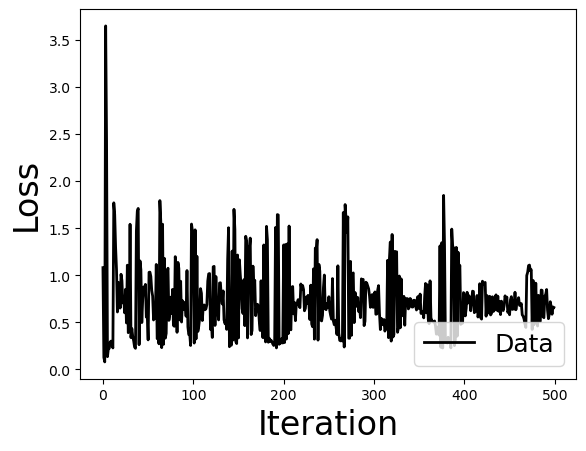

In [18]:
loss=losses[0:500]
plt.plot(range(len(loss)), loss, 'k-', label='Data', linewidth=2)
font1 = {'size': 18}
plt.legend(loc=4, prop=font1)
plt.xlabel(u'Iteration', size=24)
plt.ylabel(u'Loss', size=24)
plt.show()